Hemos optado por sólo codificar en inglés, pero las explicaciones y comentarios del código estarán en español.

Primero que nada, instalamos lo necesario e importamos las librerías necesarias. Si algún módulo no se ha importado totalmente, es porque el trabajo está desarrollado en Google Colab: por el entorno, a veces no es necesario importar todo.

In [587]:
!pip install osmnx networkx geopandas pandas shapely pyproj

In [588]:
!pip install esda splot

In [589]:
#!pip install "h3<4"
!pip install h3

In [590]:
!pip install folium

In [591]:
# Importamos todas las librerías a utilizar:
import pandas as pd
import geopandas as gpd
import requests
import time
from tqdm import tqdm # Para barras de progreso, ayuda mucho ya que la API tiene delay de 1s por cada request!!
from shapely.geometry import Point, Polygon
from shapely import wkt # Lo usaremos para parsear algunas columnas de algunos datasets a geometry, en un GDF.
import geemap,ee
import json

import h3
import numpy as np
import folium

from sklearn.cluster import DBSCAN

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import libpysal.weights
from esda.moran import Moran
from splot.esda import plot_moran

import osmnx as ox
from tqdm.auto import tqdm
import networkx as nx

from branca.colormap import linear # Para la paleta de colores

import os # Para compatibilidad del SO, unión de rutas con path.join

In [592]:
ee.Authenticate()
ee.Initialize(project='ee-aesmatias')
# Aqui, por google colab no tuve que usar un token, pero se requiere autenticacion.

In [593]:
# Esto fuerza a que se actualicen los directorios y sus contenidos en Google Colab
!ls shapefiles
!ls datasets

gadm41_USA_0.cpg  gadm41_USA_0.shx  gadm41_USA_1.shp  gadm41_USA_2.prj
gadm41_USA_0.dbf  gadm41_USA_1.cpg  gadm41_USA_1.shx  gadm41_USA_2.shp
gadm41_USA_0.prj  gadm41_USA_1.dbf  gadm41_USA_2.cpg  gadm41_USA_2.shx
gadm41_USA_0.shp  gadm41_USA_1.prj  gadm41_USA_2.dbf  manhattan.geojson
COLLEGE_UNIVERSITY_20250609.csv
gdf_rollingsales_with_hospital_dist.gpkg
gdf_rollingsales_with_subway_dist.gpkg
gdf_rollingsales_with_university_dist.gpkg
hospital_20250704.csv
MTA_Subway_Entrances_and_Exits__2024.csv
NYPD_Shooting_Incident_Data__Historic_.csv
rollingsales_manhattan_geocoded.csv
rollingsales_manhattan_geocoding_failures.csv
rollingsales_manhattan.xlsx


Descargamos el Shapefile de USA desde https://gadm.org/download_country.html, eligiendo United States y descomprimiendo el .zip, eso nos dará los archivos necesarios, luego cargamos el Shapefile de USA y filtramos el AOI en Manhattan, para finalmente de transformarlo a GEOJSON y poder utilizarlo en GEE:

In [594]:
# Nivel 2 para elegir los condados, luego lo pasamos a EPSG:4326, compatible con GEE
os_current_path = os.path.join(".", "shapefiles", "gadm41_USA_2.shp")
gdf_USA = gpd.read_file(os_current_path).to_crs(epsg=4326)

# Ruta al archivo de salida
output_dir = os.path.join(".", "shapefiles")
output_path = os.path.join(output_dir, "manhattan.geojson")

# Creamos el directorio si no existe
os.makedirs(output_dir, exist_ok=True)

ny_TO_GDF = gdf_USA[gdf_USA['NAME_2'] == 'New York'] # Seleccionamos New York
ny_TO_GDF.to_file(output_path, driver="GeoJSON") # Hacemos un .geojson y lo guardamos

In [595]:
# Cargamos el geojson creado, para que GEE lo pueda utilizar
os_current_path = os.path.join(".", "shapefiles", "manhattan.geojson")
gdf = gpd.read_file(os_current_path)
manhattan_geojson = json.loads(gdf.to_json())
manhattan_ee = ee.FeatureCollection(manhattan_geojson)

Visualizamos manhattan con GEE, podemos ajustar los parámetros como la opacidad del AOI en el mapa interactivo:

In [596]:
manhattanCollection = (ee.ImageCollection("COPERNICUS/S2_SR")
    .filterBounds(manhattan_ee)
    .filterDate("2024-05-01", "2025-04-30") # Mayo 2024 - Abril 2025
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) # Imágenes con menos de 20% de nubes
    .median() # Usamos la mediana de las imágenes de momento, sólo queremos apreciar el mapa
    .clip(manhattan_ee)) # Recortamos en Manhattan, la AOI

Map = geemap.Map(center=[40.783, -73.971], zoom=12)

Map.addLayer(manhattanCollection, {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 3000
}, 'RGB')

Map.addLayer(manhattan_ee.style(**{
    'width': 1,
    'color': 'red', # El borde será CYAN
    #'fillColor': '00000000',  # Color transparente de relleno
}), {}, 'AOI Manhattan')
Map

Map(center=[40.783, -73.971], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

Se ha utilizado el dataset de Manhattan, obtenido en https://www.nyc.gov/site/finance/property/property-rolling-sales-data.page, la fecha de los registros del dataset está entre Mayo 2024 - Abril 2025.

Aquí, en las celdas iniciales que siguen, se muestra como se han geocodificado algunos datos con ayuda de una API, pero no hace falta usarlo, porque los datos procesados ya han sido guardados en un .csv (rollingsales_manhattan_geocoded.csv)

In [597]:
'''La API que usamos para geocodificar en su capa gratuita es para testing, este proyecto
Universitario no califica como un proyecto de producción, no hay usuario final que lo utilizará.
Además, sólo hicimos uso de la API en pocas ocasiones'''

OPENCAGE_API_KEY = 'KEY'
OPENCAGE_BASE_URL = 'https://api.opencagedata.com/geocode/v1/json'

# Ruta al archivo de salida
output_dir = os.path.join(".", "datasets")

# Creamos el directorio si no existe
os.makedirs(output_dir, exist_ok=True)

input_excel_file = os.path.join(output_dir, "rollingsales_manhattan.xlsx") # XLSX con rolling sales

# Output y failed logs, para poder tener una reanudación cada 2500 request en la geocodificación
output_csv_file = os.path.join(output_dir, "rollingsales_manhattan_geocoded.csv")
failed_addresses_file = output_csv_file = os.path.join(output_dir, "rollingsales_manhattan_geocoding_failures.csv")

MAX_DAILY_REQUESTS = 2500
REQUEST_DELAY = 1.0 # seconds

REQUIRED_COLUMNS = ['ADDRESS', 'BOROUGH', 'ZIP CODE', 'SALE PRICE'] # Cols necesarias del dataset

Creamos la función que procesará cada solicitud a la API para poder geocodificar las direcciones y los ZIP codes en coordenadas geográficas que usaremos en los GDF posteriormente:

In [598]:
# Esta función hace un llamado a la API, y retorna un array con la latitud, longitud y estado
def geocode_address(address_str, api_key, borough=None, zip_code=None):
    query = f"{address_str}, {borough}, New York, NY {zip_code}" if borough and zip_code else address_str

    params = {
        'q': query,
        'key': api_key,
        'language': 'en',
        'no_annotations': 1,
        'limit': 1
    }

    try:
        response = requests.get(OPENCAGE_BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        if data and data['results']:
            lat = data['results'][0]['geometry']['lat']
            lng = data['results'][0]['geometry']['lng']

            components = data['results'][0].get('components', {})
            is_nyc = False # Empieza como false, y si lo encontramos, lo cambiamos a True:
            if 'state_code' in components and components['state_code'] == 'NY':
                if 'city' in components and components['city'] in ['New York', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island', 'Manhattan']:
                    is_nyc = True
                elif 'county' in components and ('New York County' in components['county'] or \
                                                 'Kings County' in components['county'] or \
                                                 'Queens County' in components['county'] or \
                                                 'Bronx County' in components['county'] or \
                                                 'Richmond County' in components['county']):
                    is_nyc = True

            if is_nyc:
                return lat, lng, "Success"
            else:
                return None, None, "Not_NYC_Result"
        else:
            return None, None, "No_Results"
    except requests.exceptions.RequestException as e:
        if response.status_code == 429:
            return None, None, "Rate_Limit_Exceeded"
        elif response.status_code == 401:
            print(f"API Key Error!!")
            return None, None, "API_Key_Error"
        elif response.status_code == 402: # Entonces, llegamos al límite de la quota diaria gratis
            print(f"ERROR, Quota exceded!")
            return None, None, "Payment_Required_Error"
        else:
            print(f"Request error: {e}")
            return None, None, f"Request_Error: {e}"
    except Exception as e:
        print(f"ERROR: {e}")
        return None, None, f"Error: {e}"

Comenzamos a procesar las direcciones y ZIP codes a coordenadas geográficas:

In [599]:
print(f"*** Procesando {input_excel_file} ***")

df = None
# Agregamos las columnas requeridas que fallaron a entradas del df fallido, para re intentar si se quisiera:
failed_df = pd.DataFrame(columns=REQUIRED_COLUMNS + ['Reason'])

try:
    if pd.io.common.file_exists(output_csv_file):
        print(f"Fichero '{output_csv_file}' con progreso encontrado - Resumiendo...")
        df = pd.read_csv(output_csv_file)
        # Si no hay latitud, longitud o estado de la geocodificación, sabemos que la entrada no ha sido procesada:
        for col in ['LATITUDE', 'LONGITUDE', 'GEOCODING_STATUS']:
            if col not in df.columns:
                df[col] = None
            df[col] = df[col].astype(object)

    else:
        print(f"No se encontró el fichero con progreso, cargando el fichero inicial XLSX: '{input_excel_file}'.")
        found_header = False
        # Probamos con headers desde el 0 al 10, porque algunos datasets XLSX tienen las primeras entradas con información,
        # hay que evitar las primeras entradas que no son los headers, para no obtener errores:
        for header_row_index in range(10):
            try:
                print(f"Intentando cargar con el header {header_row_index}")
                df_temp = pd.read_excel(input_excel_file, header=header_row_index)

                if all(col in df_temp.columns for col in REQUIRED_COLUMNS):
                    df = df_temp
                    found_header = True
                    print(f"Header encontrado en el índice {header_row_index}!")
                    print("Columnass encontradas en el DF:", df.columns.tolist())
                    break # Si el header es encontrado, dejamos de loopear
                else:
                    print(f"No hay header en el índice {header_row_index}, probando el siguiente...")
            except Exception as e:
                print(f"Error: {e}")

        if not found_header: # Si no hay header, hay un error en el fichero
            print(f"No se ha encontrado un header, error en el fichero XLSX")
            exit()

        # Limpiamos las columnas del DF y las parseamos
        df['ADDRESS'] = df['ADDRESS'].fillna('').astype(str)
        df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].fillna('').astype(str)
        df['BOROUGH'] = df['BOROUGH'].fillna('').astype(str)
        df['ZIP CODE'] = df['ZIP CODE'].fillna(0).astype(int).astype(str).replace('0', '')

        # Agregamos la latitud, longitud, y estado de la geocodificación, como nuevas columnas en el DF:
        df['LATITUDE'] = None
        df['LONGITUDE'] = None
        df['GEOCODING_STATUS'] = None

    already_geocoded_count = df['LATITUDE'].notna().sum()
    requests_made_now = 0
    print(f"Los registros geocodificados hasta el momento son: {already_geocoded_count}")

    # La siguiente línea veririfica si la latitud está vacía y el "status" es diferente de "Not_NYC_Result"
    # Si el registro tiene GEOCODIG_STATUS = 'Not_NYC_Result', entonces ha fallado la geocodificación.
    rows_to_geocode = df[(df['LATITUDE'].isna()) & (df['GEOCODING_STATUS'] != 'Not_NYC_Result')]

    print(f"Han fallado: {len(rows_to_geocode)} registros")

    for index, row in tqdm(rows_to_geocode.iterrows(), total=len(rows_to_geocode), desc="Geocoding"): #tqdm para barra de progrso
        if requests_made_now >= MAX_DAILY_REQUESTS:
            print(f"Se ha llegado al límite de {MAX_DAILY_REQUESTS} requests diarias!")
            break

        address = row['ADDRESS']
        borough = row['BOROUGH']
        zip_code = row['ZIP CODE'] if row['ZIP CODE'] != '0' else ''

        if not address:
            df.loc[index, 'GEOCODING_STATUS'] = "Empty_Address"
            continue

        lat, lon, status = geocode_address(address, OPENCAGE_API_KEY, borough, zip_code)
        requests_made_now += 1

        df.loc[index, 'LATITUDE'] = lat
        df.loc[index, 'LONGITUDE'] = lon
        df.loc[index, 'GEOCODING_STATUS'] = status

        if status in ["Rate_Limit_Exceeded", "API_Key_Error", "Payment_Required_Error"]:
            break

        time.sleep(REQUEST_DELAY) # La documentación de la API indica un delay de 1 segundo entre cada request

        # Guardamos el progreso en chunks de cada 100 solicitudes a la API:
        if requests_made_now % 100 == 0:
            print(f"Guardando progreso en la request número {requests_made_now}")
            df.to_csv(output_csv_file, index=False)

    df.to_csv(output_csv_file, index=False)
    print(f"Geocodificación finalizada!!")

    failed_rows = df[df['LATITUDE'].isna()] # Si no tiene latitud, es una row fallida
    if not failed_rows.empty:
        failed_df_to_save = failed_rows[['BOROUGH', 'NEIGHBORHOOD', 'ADDRESS', 'ZIP CODE', 'GEOCODING_STATUS']].copy()
        # Guardamos en failed_addresses_file sólo las rows de la variable de arriba, para poder procesarlas luego.
        failed_df_to_save.to_csv(failed_addresses_file, index=False)
        print(f"Los registros fallidos se guardaron en: {failed_addresses_file}")
    else:
        print("Atención! Finalización inesperada, posiblemente ha ocurrido un error.")

except FileNotFoundError:
    print(f"ERROR: Archivo '{input_excel_file}' no hallado.")
except Exception as e:
    print(f"ERROR: {e}")

*** Procesando ./datasets/rollingsales_manhattan.xlsx ***
Fichero './datasets/rollingsales_manhattan_geocoding_failures.csv' con progreso encontrado - Resumiendo...
Los registros geocodificados hasta el momento son: 0
Han fallado: 4 registros


Geocoding:   0%|          | 0/4 [00:00<?, ?it/s]

API Key Error!!
Geocodificación finalizada!!
Los registros fallidos se guardaron en: ./datasets/rollingsales_manhattan_geocoding_failures.csv


Cargamos el fichero con la latitud y longitud agregadas en la geocodificación, para luego, filtrar los registros que tengan NaN en latitud y longitud, ya que eso es producto de errores en la geocodificación de dichos valores. También cribamos y sólo tomamos como válidos valores con precio de venta mayor a 0, ya que hay varios valores en el dataset con propiedades que se han vendido a costo 0, lo que no tiene representación estadística en nuestro contexto.

In [600]:
properties_geocoded_file = os.path.join(".", "datasets", "rollingsales_manhattan_geocoded.csv")

try:
    df_properties = pd.read_csv(properties_geocoded_file)
    print(f"***Cargando fichero: {properties_geocoded_file}*** \n")
    print(f"Cantidad de registros encontrados en {str(properties_geocoded_file)}: {len(df_properties)} \n")
    print("df_properties.info(): \n")
    print(df_properties.info())

except Exception as e:
    print(f"Error: {str(e)}")
    exit()

# Eliminamos los registros que sean NaN en latitud y longitud.
df_properties.dropna(subset=['LATITUDE', 'LONGITUDE'], inplace=True)
print(f"Registros después de eliminar NaN en lat/lon: {len(df_properties)}")

# Transformamos todo SALE PRICE a numeric, para luego, con coerce, reemplazar los valores no numericos a NaN
df_properties['SALE PRICE'] = pd.to_numeric(df_properties['SALE PRICE'], errors='coerce')
# Luego,eliminamos todas esas filas que contienen NaN
df_properties.dropna(subset=['SALE PRICE'], inplace=True)
print(f"Registros después de filtrar por NaN: {len(df_properties)}")

# Eliminamos los registros que tengan precio de venta menor o igual a 0, sin representación estadística.
df_properties = df_properties[df_properties['SALE PRICE'] > 0]
print(f"Registros después de filtrar por precio de venta > 0: {len(df_properties)}")

# Filtramos duplicados
initial_rows_before_deduplication = len(df_properties)
df_properties.drop_duplicates(inplace=True)
print(f"Registros después de filtrar por posibles duplicados: {len(df_properties)}")

***Cargando fichero: ./datasets/rollingsales_manhattan_geocoded.csv*** 

Cantidad de registros encontrados en ./datasets/rollingsales_manhattan_geocoded.csv: 17738 

df_properties.info(): 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17738 entries, 0 to 17737
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         17738 non-null  int64  
 1   NEIGHBORHOOD                    17738 non-null  object 
 2   BUILDING CLASS CATEGORY         17738 non-null  object 
 3   TAX CLASS AT PRESENT            17738 non-null  object 
 4   BLOCK                           17738 non-null  int64  
 5   LOT                             17738 non-null  int64  
 6   EASEMENT                        0 non-null      float64
 7   BUILDING CLASS AT PRESENT       17738 non-null  object 
 8   ADDRESS                         17738 non-null  object 
 9   APARTMENT NUMBER         

Luego, para una posterior manipulación y tener una mayor compatibilidad con GEE y librerías para graficar, "transformamos" el dataframe a un geodataframe, y le agregamos una nueva columna de tipo geometry, que contendrá puntos generados a través de las propiedades de latitud y longitud, los cuales están definidos en la variable geometry, haciendo uso del métetodo zip y list comprehension.

In [601]:
# A partir de las coordenadas, creamos objetos de tipo Point, de la librería shapely.geometry, para luego manipular mejor:
geometry = [Point(xy) for xy in zip(df_properties['LONGITUDE'], df_properties['LATITUDE'])]

# Creamos el nuevo geodataframe para, a partir del dataframe anterior, llenarlo con los datos:
gdf_properties = gpd.GeoDataFrame(df_properties, geometry=geometry, crs="EPSG:4326") #CRS es EPSG:4326 para latitud y longitud.

print("Nuevo GeoDataFrame:")
gdf_properties.info()

Nuevo GeoDataFrame:
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 1708 entries, 2 to 17737
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         1708 non-null   int64   
 1   NEIGHBORHOOD                    1708 non-null   object  
 2   BUILDING CLASS CATEGORY         1708 non-null   object  
 3   TAX CLASS AT PRESENT            1708 non-null   object  
 4   BLOCK                           1708 non-null   int64   
 5   LOT                             1708 non-null   int64   
 6   EASEMENT                        0 non-null      float64 
 7   BUILDING CLASS AT PRESENT       1708 non-null   object  
 8   ADDRESS                         1708 non-null   object  
 9   APARTMENT NUMBER                598 non-null    object  
 10  ZIP CODE                        1708 non-null   int64   
 11  RESIDENTIAL UNITS               1160 non-null   float64 
 

Cargamos el dataset https://catalog.data.gov/dataset/nypd-shooting-incident-data-historic que contiene el histórico de tiroteos.

In [602]:
shooting_incident_historic = os.path.join(output_dir, "NYPD_Shooting_Incident_Data__Historic_.csv")

df_shooting_incident_historic = None

try:
    df_shooting_incident_historic = pd.read_csv(shooting_incident_historic)
    print(f"El archivo {shooting_incident_historic} ha sido cargado \n")
    print(f'Información del fichero: \n')
    df_shooting_incident_historic.info()
except Exception as e:
    print(f"Error: {e}")

El archivo ./datasets/NYPD_Shooting_Incident_Data__Historic_.csv ha sido cargado 

Información del fichero: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29744 entries, 0 to 29743
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             29744 non-null  int64  
 1   OCCUR_DATE               29744 non-null  object 
 2   OCCUR_TIME               29744 non-null  object 
 3   BORO                     29744 non-null  object 
 4   LOC_OF_OCCUR_DESC        4148 non-null   object 
 5   PRECINCT                 29744 non-null  int64  
 6   JURISDICTION_CODE        29742 non-null  float64
 7   LOC_CLASSFCTN_DESC       4148 non-null   object 
 8   LOCATION_DESC            14767 non-null  object 
 9   STATISTICAL_MURDER_FLAG  29744 non-null  bool   
 10  PERP_AGE_GROUP           20400 non-null  object 
 11  PERP_SEX                 20434 non-null  object 
 12  PERP_RACE           

 Al igual que antes, este dataset también debe ser filtrado por fecha de interés y ser convertido a GDF, la columna con el Point, que contiene la geometría de la latitud y longitud, está en una columna llamada "Lon_Lat", y contiene valores de tipo Point.

In [603]:
LATITUDE_COL = 'Latitude'
LONGITUDE_COL = 'Longitude'
INCIDENT_DATE_COL = 'OCCUR_DATE'
BORO_COL = 'BORO'
year_of_preference = 2024 # Nos interesan datos de tiroteos en los últimos 2 años

# Cargamos el archivo y definimos una variable para su dataframe
shooting_incident_historic = os.path.join(".", "datasets", "NYPD_Shooting_Incident_Data__Historic_.csv")

try:
    df_shooting_incident_historic = pd.read_csv(shooting_incident_historic)
    print(f"El archivo {shooting_incident_historic} ha sido cargado. Su longitud es: {len(df_shooting_incident_historic)} \n")
except Exception as e:
    print(f"Error: {e}")

# Eliminamos las filas con NaN en las coordenadas
df_shooting_incident_historic.dropna(subset=[LATITUDE_COL, LONGITUDE_COL], inplace=True)

# Eliminamos las filas duplicadas
df_shooting_incident_historic.drop_duplicates(inplace=True)
print(f"Registros luego de eliminar posibles duplicados: {len(df_shooting_incident_historic)}")

# Si la columna con fecha del incidente existe, filtramos por BORO y AÑO:
if INCIDENT_DATE_COL in df_shooting_incident_historic.columns:
    # Convertimos la columna de OCCUR_DATE a datatime de pandas, para trabajarla con el formato de USA:
    df_shooting_incident_historic[INCIDENT_DATE_COL] = pd.to_datetime(
        df_shooting_incident_historic[INCIDENT_DATE_COL],
        format='%m/%d/%Y',
        errors='coerce' # Los valores sin fecha válida serán NaT
    )
    # Dropeamos valores sin fecha válida (NaT)
    df_shooting_incident_historic.dropna(subset=[INCIDENT_DATE_COL], inplace=True)
    df_shooting_incident_historic['INCIDENT_YEAR'] = df_shooting_incident_historic[INCIDENT_DATE_COL].dt.year

    # Filtramos para sólo obtener datos de Manhattan (en la col BORO)
    if BORO_COL in df_shooting_incident_historic.columns:
        # Usamos .copy() para definir la variable por valor, y no por referencia en memoria:
        df_shooting_incident_manhattan = df_shooting_incident_historic[df_shooting_incident_historic[BORO_COL] == 'MANHATTAN'].copy()
        print(f"Encontramos: {len(df_shooting_incident_manhattan)} incidentes en Manhattan")

        # Filtramos según el año deseado:
        df_shooting_incident_manhattan = df_shooting_incident_manhattan[df_shooting_incident_manhattan['INCIDENT_YEAR'] >= year_of_preference]
        print(f"Encontramos: {len(df_shooting_incident_manhattan)} incidentes posteriores al año {year_of_preference}. \n")

        # Antes de convertir el DF a GDF, necesitamos col geometry que contiene puntos, los cuales están en la
        # columna Lon_Lat, por lo que la parseamos:
        df_shooting_incident_manhattan['Lon_Lat'] = df_shooting_incident_manhattan['Lon_Lat'].apply(wkt.loads)

        # Creamos el GeoDataFrame de los incidentes y lo asignamos en una nueva variable:
        geometry_incidents = [Point(xy) for xy in zip(df_shooting_incident_manhattan[LONGITUDE_COL], df_shooting_incident_manhattan[LATITUDE_COL])]

        # Renombramos la columna Lon_Lat a geometry, ya que sabemos que existe Lon_Lat, que es un tipo de dato Point
        df_shooting_incident_manhattan.rename(columns={'Lon_Lat': 'geometry'}, inplace=True)

        # Creamos el GDF utilizando la col geometry:
        gdf_incidents = gpd.GeoDataFrame(df_shooting_incident_manhattan, geometry='geometry', crs="EPSG:4326")  # CRS 4326 para lat/lon

        print("Información del GDF:")
        gdf_incidents.info()
    else:
      raise KeyError(f"Error: La columna '{BORO_COL}' no se encontró!! ")

El archivo ./datasets/NYPD_Shooting_Incident_Data__Historic_.csv ha sido cargado. Su longitud es: 29744 

Registros luego de eliminar posibles duplicados: 29647
Encontramos: 3953 incidentes en Manhattan
Encontramos: 207 incidentes posteriores al año 2024. 

Información del GDF:
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 207 entries, 28572 to 29742
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   INCIDENT_KEY             207 non-null    int64         
 1   OCCUR_DATE               207 non-null    datetime64[ns]
 2   OCCUR_TIME               207 non-null    object        
 3   BORO                     207 non-null    object        
 4   LOC_OF_OCCUR_DESC        207 non-null    object        
 5   PRECINCT                 207 non-null    int64         
 6   JURISDICTION_CODE        207 non-null    float64       
 7   LOC_CLASSFCTN_DESC       207 non-null    object      

Cargamos y limpiamos el dataset de universidades y college. Es importante notar que hay puntos por fuera de la AOI de Manhattan en algunos datasets, como por ejemplo en la universidades, esto es porque es del todo natural que hayan personas viviendo en el distrito de Manhattan que quieran estudiar en las cercanías del distrito próximo, por eso no se ha limitado el conjunto de datos de éstos datasets, tiene mucho sentido dejarlo como está.

In [604]:
# Definimos la ruta del dataset
college_university_file = os.path.join(".", "datasets", "COLLEGE_UNIVERSITY_20250609.csv")
df_college_university = None

# Esta propiedad en el dataset es un Punto siempre, según la página que lo provee:
GEOMETRY_COL = 'the_geom'

try:
    df_college_university = pd.read_csv(college_university_file)
    print(f"El archivo {college_university_file} ha sido cargado. Su longitud es: {len(df_college_university)} \n")
except Exception as e:
    print(f"Error: {e}")

#Limpieza de nulos:
df_college_university.dropna(subset=[GEOMETRY_COL], inplace=True)
print(f"Registros luego de eliminar NaNs en la columna '{GEOMETRY_COL}': {len(df_college_university)}")

#Limpieza de duplicados
df_college_university.drop_duplicates(inplace=True)
print(f"Registros luego de eliminar posibles duplicados: {len(df_college_university)}")

if GEOMETRY_COL in df_college_university.columns:
    #Parseamos los datos de la columna the_geom y los agregamos a la llamada 'geometry' para poder trabajarlas:
    df_college_university['geometry'] = df_college_university[GEOMETRY_COL].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)
    df_college_university.dropna(subset=['geometry'], inplace=True)
    print(f"Registros luego de parsear la col '{GEOMETRY_COL}' a la col geometry: {len(df_college_university)}")

    gdf_universities = gpd.GeoDataFrame(df_college_university, geometry='geometry', crs="EPSG:4326") #Aplicamos la proyección correcta

    print("\nInformación del GeoDataFrame de Universidades:")
    gdf_universities.info()

    # Mostramos el mapa
    Map = geemap.Map(center=[40.7, -74.0], zoom=12)
    ee_universities = geemap.geopandas_to_ee(gdf_universities)
    try:

            # Cargamos el dataset Sentinel-2 L2A (surface reflectance) para mostrar las bandas RGB, y filtramos por AOI y fecha: Mayo 2024 - Abril 2025
            s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
                .filterBounds(manhattan_ee) \
                .filterDate("2024-05-01", "2025-04-30") \
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) # Imágenes con porcentaje de nubes menor a 20

            # Verificamos que la colección no esté vacía para el intervalo de fechas solicitada:
            if s2_collection.size().getInfo() > 0:
                s2_image = s2_collection.median().clip(manhattan_ee) # Calculamos la mediana de imágenes y recortamos al AOI

                s2_vis_params = {
                    'bands': ['B4', 'B3', 'B2'], # B4=Red, B3=Green, B2=Blue
                    'min': 0,
                    'max': 3000,
                    'gamma': 1.4
                }

                Map.addLayer(s2_image, s2_vis_params, 'RGB') # Agregamos la layer al mapa
            else:
                print("El dataset no tiene imágnes para la fecha de interés.")

            # Agregamos una layer con los puntos, que representan las ubicaciones de las ubicaciones de los centros de estudio:
            Map.addLayer(ee_universities, {'color': 'red', 'opacity': 0.9, 'point_size': 2}, 'University Locations')

    except Exception as e:
        print(f"Error: {e}")

    display(Map) # A veces hay que usar display para mostrar el mapa

else:
    raise KeyError(f"Error: '{GEOMETRY_COL}' no existe en el CSV.")

El archivo ./datasets/COLLEGE_UNIVERSITY_20250609.csv ha sido cargado. Su longitud es: 77 

Registros luego de eliminar NaNs en la columna 'the_geom': 77
Registros luego de eliminar posibles duplicados: 77
Registros luego de parsear la col 'the_geom' a la col geometry: 77

Información del GeoDataFrame de Universidades:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   the_geom    77 non-null     object  
 1   NAME        77 non-null     object  
 2   HOUSENUM    76 non-null     object  
 3   STREETNAME  77 non-null     object  
 4   CITY        77 non-null     object  
 5   ZIP         77 non-null     int64   
 6   URL         77 non-null     object  
 7   BIN         77 non-null     int64   
 8   BBL         74 non-null     float64 
 9   geometry    77 non-null     geometry
dtypes: float64(1), geometry(1), int64(2), object(6)
memory usag

Map(center=[40.7, -74.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

Cargamos y limpiamos el dataset de hospitales en NYC.

In [605]:
hospital_filename = os.path.join(".", "datasets", "hospital_20250704.csv")
df_hospitals = None

# Según el dataset, los puntos de ubicación están en el atributo llamado "Location 1", luego lo agregaremos como geometry:
GEOMETRY_COL = 'Location 1'

try:
    df_hospitals = pd.read_csv(hospital_filename)
    print(f"El archivo {hospital_filename} ha sido cargado. Su longitud es: {len(df_hospitals)} \n")
except Exception as e:
    print(f"Error: {e}")

# Limpieza de nulos en la columna de geometría:
df_hospitals.dropna(subset=[GEOMETRY_COL], inplace=True)
print(f"Registros luego de eliminar NaNs en la columna '{GEOMETRY_COL}': {len(df_hospitals)}")

# Limpieza de duplicados
df_hospitals.drop_duplicates(inplace=True)
print(f"Registros luego de eliminar posibles duplicados: {len(df_hospitals)}")

if GEOMETRY_COL in df_hospitals.columns:
    # Parseamos los datos de la columna de geometría y los agregamos a la nueva columna 'geometry'
    df_hospitals['geometry'] = df_hospitals[GEOMETRY_COL].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)
    df_hospitals.dropna(subset=['geometry'], inplace=True)
    print(f"Registros luego de parsear la col '{GEOMETRY_COL}' a la col geometry: {len(df_hospitals)}")

    # Creamos el GeoDataFrame con la proyección correcta (EPSG:4326)
    gdf_hospitals = gpd.GeoDataFrame(df_hospitals, geometry='geometry', crs="EPSG:4326")

    print("\nInformación del GeoDataFrame de Hospitales:")
    gdf_hospitals.info()

    Map = geemap.Map(center=[40.76, -73.98], zoom=12) # Centrado en Manhattan

    # Convertimos el GeoDataFrame a un Earth Engine FeatureCollection
    ee_hospitals = geemap.geopandas_to_ee(gdf_hospitals)

    try:
        # Cargamos el dataset Sentinel-2 L2A y filtramos por AOI y fecha: Mayo 2024 - Abril 2025
        s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(manhattan_ee) \
            .filterDate("2024-05-01", "2025-04-30") \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) # Imágenes con < 20% de nubes

        # Verificamos que la colección no esté vacía
        if s2_collection.size().getInfo() > 0:
            s2_image = s2_collection.median().clip(manhattan_ee) # Calculamos la mediana y recortamos al AOI

            s2_vis_params = {
                'bands': ['B4', 'B3', 'B2'], # R, G, B
                'min': 0,
                'max': 3000,
                'gamma': 1.4
            }

            Map.addLayer(s2_image, s2_vis_params, 'RGB') # Agregamos la capa de imagen satelital
        else:
            print("El dataset no tiene imágenes para la fecha de interés.")

        # Agregamos la capa con los puntos de los hospitales
        Map.addLayer(ee_hospitals, {'color': 'blue', 'opacity': 0.9, 'point_size': 2}, 'Hospital Locations')

    except Exception as e:
        print(f"Error: {e}")

    display(Map)

else:
    raise KeyError(f"Error: La columna '{GEOMETRY_COL}' no existe en el archivo CSV.")

El archivo ./datasets/hospital_20250704.csv ha sido cargado. Su longitud es: 78 

Registros luego de eliminar NaNs en la columna 'Location 1': 78
Registros luego de eliminar posibles duplicados: 78
Registros luego de parsear la col 'Location 1' a la col geometry: 78

Información del GeoDataFrame de Hospitales:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Facility Type  78 non-null     object  
 1   Borough        78 non-null     object  
 2   Facility Name  78 non-null     object  
 3   Cross Streets  27 non-null     object  
 4   Phone          78 non-null     object  
 5   Location 1     78 non-null     object  
 6   geometry       78 non-null     geometry
dtypes: geometry(1), object(6)
memory usage: 4.4+ KB


Map(center=[40.76, -73.98], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

Cargamos y limpiamos el dataset de las entradas al metro de NYC.

In [606]:
subway_filename = os.path.join(".", "datasets", "MTA_Subway_Entrances_and_Exits__2024.csv")
df_subway = None

# Según el dataset, los puntos de ubicación están en el atributo llamado "entrance_georeference", luego lo agregaremos como geometry:
GEOMETRY_COL = 'entrance_georeference'

try:
    df_subway = pd.read_csv(subway_filename)
    print(f"El archivo {subway_filename} ha sido cargado. Su longitud es: {len(df_subway)} \n")
except Exception as e:
    print(f"Error: {e}")

# Limpieza de nulos en la columna de geometría:
df_subway.dropna(subset=[GEOMETRY_COL], inplace=True)
print(f"Registros luego de eliminar NaNs en la columna '{GEOMETRY_COL}': {len(df_subway)}")

# Limpieza de duplicados
df_subway.drop_duplicates(inplace=True)
print(f"Registros luego de eliminar posibles duplicados: {len(df_subway)}")

if GEOMETRY_COL in df_subway.columns:
    # Parseamos los datos de la columna de geometría y los agregamos a la nueva columna 'geometry'
    df_subway['geometry'] = df_subway[GEOMETRY_COL].apply(lambda x: wkt.loads(x) if pd.notna(x) else None)
    df_subway.dropna(subset=['geometry'], inplace=True)
    print(f"Registros luego de parsear la col '{GEOMETRY_COL}' a la col geometry: {len(df_subway)}")

    # Creamos el GeoDataFrame con la proyección correcta (WGS84)
    gdf_subway = gpd.GeoDataFrame(df_subway, geometry='geometry', crs="EPSG:4326")

    print("\nInformación del GeoDataFrame de Entradas de Subterráneo:")
    gdf_subway.info()

    Map = geemap.Map(center=[40.76, -73.98], zoom=12) # Centrado en Manhattan

    # Convertimos el GeoDataFrame a un Earth Engine FeatureCollection
    ee_subway = geemap.geopandas_to_ee(gdf_subway)

    try:
        # Cargamos el dataset Sentinel-2 L2A y filtramos por AOI y fecha
        s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(manhattan_ee) \
            .filterDate("2024-05-01", "2025-04-30") \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

        # Verificamos que la colección no esté vacía
        if s2_collection.size().getInfo() > 0:
            s2_image = s2_collection.median().clip(manhattan_ee)

            s2_vis_params = {
                'bands': ['B4', 'B3', 'B2'], # R, G, B
                'min': 0,
                'max': 3000,
                'gamma': 1.4
            }
            Map.addLayer(s2_image, s2_vis_params, 'RGB')
        else:
            print("El dataset no tiene imágenes para la fecha de interés.")

        # Agregamos la capa con los puntos de las entradas al metro
        Map.addLayer(ee_subway, {'color': 'orange', 'pointSize': 2}, 'Subway entrances')

    except Exception as e:
        print(f"Error: {e}")

    display(Map)

else:
    raise KeyError(f"Error: La columna '{GEOMETRY_COL}' no existe en el archivo CSV.")

El archivo ./datasets/MTA_Subway_Entrances_and_Exits__2024.csv ha sido cargado. Su longitud es: 2120 

Registros luego de eliminar NaNs en la columna 'entrance_georeference': 2120
Registros luego de eliminar posibles duplicados: 2120
Registros luego de parsear la col 'entrance_georeference' a la col geometry: 2120

Información del GeoDataFrame de Entradas de Subterráneo:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Division                  2120 non-null   object  
 1   Line                      2120 non-null   object  
 2   Borough                   2120 non-null   object  
 3   Stop Name                 2120 non-null   object  
 4   Complex ID                2120 non-null   int64   
 5   Constituent Station Name  2120 non-null   object  
 6   Station ID                2120 non-null   int64   
 7   GT

Map(center=[40.76, -73.98], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

Al igual que en la tarea 2, usamos el NDBI.
(Sitio web de interés: https://www.gisandbeers.com/calculo-indice-ndbi-analisis-urbanisticos/)

Revisando el estudio de
https://revistas.uptc.edu.co/index.php/ingenieria_sogamoso/article/view/15018/12232 Me inclino a considerar al NDBI como un buen índice espectral para utilizar. Aunque se concluye del estudio en Colombia que, si bien éste índice es el que mostró mejor resultados en las zonas mencionadas ahí, no es una regla general.

El NDBI (Normalized Difference Built-up Index) es un índice espectral diseñado para resaltar las zonas construidas, de ahí el nombre de las siglas. Se basa en el cálculo mediante la fórmula presente en el sitio web de interés, como también en el estudio, ambos enlaces más arriba, la fórmula se basa en el contraste entre la reflectancia del infrarrojo de onda corta (SWIR) y del infrarrojo cercano (NIR), que en el caso de nuestro dataset utilizado (Sentinel-2), equivalen a las bandas B11 y B8, respectivamente. Si bien para el caso de una representación visual corriente representamos las capas (layers) en un mapa con las bandas RGB, que equivalen a las bandas B4, B3 y B2 respectivamente, en este caso utilizamos estas otras bandas para poder estudiar de mejor manera las zonas construidas o edificaciones. Diferentes datasets provienen de diferentes satélites con diferentes sensores, así que no todos los satélites trabajan con las mismas bandas, por lo que en imágenes muy antiguas puede ser que no estén disponbles las bandas de los datasets actuales, como las del Sentinel-2.

Fórmulas:

NDBI = (SWIR - NIR) / (SWIR + NIR)

Misma fórmula, pero reemplazando las radiaciones electromagnéticas SWIR y NIR por sus equivalentes en bandas para el Sentinel-2:

NDBI = (Banda 11 - Banda 8) / (Banda 11 + Banda 8)

Las equivalencias entre SWIR y NIR con las bandas 11 y 8 fueron obtenidas de https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#bands

Aprovechamos de hacer el mismo cálculo para el NDVI (índice de vegetación).

https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index


https://www.auravant.com/en/articles/precision-agriculture/vegetation-indices-and-their-interpretation-ndvi-gndvi-msavi2-ndre-and-ndwi/


https://mappinggis.com/2015/06/ndvi-que-es-y-como-calcularlo-con-saga-desde-qgis/

In [607]:
Map = geemap.Map(center=[40.7, -74.0], zoom=12) #Definimos el mapa y centro

#Pasamos un GDF a FeatureCollection de GEE, para poder utilizarlo en GEE posteriormente:
#ee_universities = geemap.geopandas_to_ee(gdf_universities)

# Esto es boilerplate de la tarea 2, código genérico para calcular el NDBI:
def getNDBI(image):
    # Calculamos el NDBI con las Bandas B11 (SWIR 1) y B8 (NIR). Formula: (SWIR - NIR) / (SWIR + NIR)
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
    return ndbi

## NDVI (que corresponde al indice de Vegetación)
def getNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return ndvi

s2_collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(manhattan_ee) \
    .filterDate("2024-05-01", "2025-04-30") \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) # Imágenes con nubosidad menor al 20%

if s2_collection.size().getInfo() > 0: #Verificamos que la colección tenga imágenes
    s2_image_median = s2_collection.median().clip(manhattan_ee)

    # Calculamos el NDBI y el NDVI para la mediana de las imágnes del dataset, previamente clippeado por el AOI.
    ndbi_image = getNDBI(s2_image_median)
    ndvi_image = getNDVI(s2_image_median) ## NUEVO

    # Parámetros para NDBI
    ndbi_vis_params = {
        'min': -0.5, 'max': 0.5,
        'palette': [
            'blue',    # Agua (NDBI muy bajo)
            'green',   # Vegetación sana
            'yellow',  # Suelo desnudo / vegetación dispersa
            'red',     # Transición / áreas urbanizadas menos densas
            'white'    # Áreas altamente urbanizadas (NDBI alto)
        ]
    }

    # Parámetros para NDVI
    ndvi_vis_params = {
        'min': -0.1, 'max': 0.8, # Hay que cambiar el min y max con respecto al NDBI
        # La paleta va desde el suelo sin vegetación (brown) hasta mucha vegetación (darkgreen)
        'palette': ['brown', 'yellow', 'lightgreen', 'green', 'darkgreen']
    }

    # Parámetros para la imagen RGB
    s2_rgb_vis_params = {
        'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.4
    }

    # Agregamos la layer RGB, NDVI y NDBI para mostrar en el mapa
    Map.addLayer(s2_image_median, s2_rgb_vis_params, 'RGB')
    Map.addLayer(ndbi_image, ndbi_vis_params, 'NDBI - Índice de urbanización')
    Map.addLayer(ndvi_image, ndvi_vis_params, 'NDVI - Índice de vegetación')

else:
    print("No se han hallado imágenes para el dataset en las fechas de interés.")

display(Map)

Map(center=[40.7, -74.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

Aquí, hacemos reproyecciones de los datasets para pasarlos del sistema angular a unidades medidas en pies(ft), para así hacer las mediciones posteriores de distancias más facilmente. Para ello, hemos utilizado el sitio web https://epsg.io/, que nos ayuda a encontrar la proyección adecuada para cada lugar del mundo, en este caso New York City. Usamos, en vez de la la proyeccion EPSG:32118 que mide en metros, la proyecciön 2263 medida en pies, ya que está diseñada específicamente para NYC. Probando con el CRS EPSG:32118 los resultados fueron mucho menos precisos.

In [608]:
crs_meters_nyc = "EPSG:2263"

print(f"Haciendo reproyección de los datasets a {crs_meters_nyc}...")

gdf_properties_proj_ft = gdf_properties.to_crs(crs_meters_nyc)
gdf_incidents_proj_ft = gdf_incidents.to_crs(crs_meters_nyc)
gdf_subway_proj_ft = gdf_subway.to_crs(crs_meters_nyc)
gdf_hospitals_proj_ft = gdf_hospitals.to_crs(crs_meters_nyc)

Haciendo reproyección de los datasets a EPSG:2263...


Hacemos un agrupamiento (clustering) de los lugares donde han ocurrido tiroteos registrados en el dataset cargado anteriormente (gdf_incidents*). Para ello, usamos el algoritmo DBSCAN.

Se debe limpiar el GDF de incidentes con .drop_duplicates() por duplicados, y también para nulos, pero el dataset ya ha sido limpiado al cargarse, por lo que no es necesario, se ha puesto un print para verificar que no hay duplicados.

Recordar que la región de agrupamiento epsilon=eps está en ft (foots, pies), no en metros.

Es importante considerar que los verdaderos repetidos no necesariamente consisten en las coordenadas repetidas, sino en registros que pueden tener fechas similares, ya que no es para nada imposible que se registren tiroteos en zonas donde ya han ocurrido previamente tiroteos, lo correcto sería asegurarse que no hay repetición temporal sobre la misma zona, idealmente con un epsilon en cada punto para verificar si hay duplicado del mismo registro, pero en nuestra pequeña base de datos de incidentes no es relevante.

In [609]:
gdf_incidents_proj_ft_cleaned = gdf_incidents_proj_ft.drop_duplicates() # Eliminamos duplicados
gdf_incidents_proj_ft_cleaned.reset_index(drop=True) # Reseteamos el índice luego de dropear duplicados.

print(f"Número de filas completamente duplicadas eliminadas: {len(gdf_incidents_proj_ft) - len(gdf_incidents_proj_ft_cleaned)}")

# Iniciamos el algoritmo de clustering DBSCAN para un epsilon de 700ft y un mínimo de 2 incidentes.
model = DBSCAN(eps=700, min_samples=2)
labels = model.fit_predict(
    pd.DataFrame({
        'x': gdf_incidents_proj_ft_cleaned.geometry.x,
        'y': gdf_incidents_proj_ft_cleaned.geometry.y
    })
)

gdf_incidents_proj_ft_cleaned['label'] = labels

set_labels = set(labels) # El set elimina duplicados
#Al set de labels, le restamos 1 si es que existen puntos sin cluster (label -1), de lo contrario, no.
number_clusters = len(set_labels) - (1 if -1 in labels else 0)

list_labels = list(labels) # La lista conserva el orden y no elimina duplicados.
number_noises = list_labels.count(-1) # Contamos cantidad de labels que son -1

print(f"Se han hallado {number_clusters} clusters.") # Los valores sin -1 como label, son clusters
print(f"Numero de puntos ruido: {number_noises}")

Número de filas completamente duplicadas eliminadas: 0
Se han hallado 47 clusters.
Numero de puntos ruido: 35


Luego de haber aplicado el algoritmo para los puntos y obtenido los labels para cada punto, podemos hacer uso de los puntos que están agrupados en clusters y los que son ruido, para poder visualizarlos.

In [610]:
# Reproyectamos el GDF para usar ángulos (latitud, longitud)
gdf_incidents_proj_ft_cleaned_epsg4326 = gdf_incidents_proj_ft_cleaned.to_crs("EPSG:4326")
gdf_map_epsg4326 = gdf_incidents_proj_ft_cleaned_epsg4326.copy() # Copiamos para acortar el nombre

# Creamos el mapa centrado en NYC para mostrar los puntos de tiroteos sobre Manhattan.
mapa = folium.Map(location=[40.73, -73.9], zoom_start=11, tiles="CartoDB positron")

# Seleccionamos nuevamente los puntos ruido para poder graficarlos en gris en el folium.
noise_points = gdf_map_epsg4326[gdf_map_epsg4326['label'] == -1]

for _, row in noise_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color='gray',
        fill=True,
        fill_color='gray',
        fill_opacity=0.5,
        popup='Puntos de ruido'
    ).add_to(mapa)

# Extraemos los labels únicos, excluyendo los que son -1 (ruido)
unique_labels = gdf_map_epsg4326['label'].unique()
unique_labels = unique_labels[unique_labels != -1]

# Creamos una paleta de 20 colores para ver los clusters.
colors = plt.cm.get_cmap('tab20', len(unique_labels))

# Folium necesita que se parseen los colores a hexadecimal, loopeamos con enumerate y parseamos:
label_to_color = {label: mcolors.rgb2hex(colors(i)) for i, label in enumerate(unique_labels)}

# Hacemos lo mismo que con los puntos de ruido pero con los clusters, los seleccionamos y los graficamos en el folium:
cluster_points = gdf_map_epsg4326[gdf_map_epsg4326['label'] != -1]

for _, row in cluster_points.iterrows():

    # El color dependerá de la label del punto, a cuál cluster pertenece:
    color = label_to_color[row['label']]

    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=1,
        popup=f"Cluster perteneciente al label {row['label']}"
    ).add_to(mapa)

display(mapa)

Aquí, se ha tomado como referencia esta explicación de Moran:
https://pro.arcgis.com/es/pro-app/latest/tool-reference/spatial-statistics/h-how-spatial-autocorrelation-moran-s-i-spatial-st.htm, además de https://pro.arcgis.com/es/pro-app/latest/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm, junto con la clase online grabada donde se menciona el algoritmo K-means y el DBSCAN, como también HDBSCAN y diferentes variantes de algoritmos de clustering o agrupación de la librería [scikit-learn](https://scikit-learn.org). Parte de este código fue tomado tomando como referencia la tarea 3.

Entonces, para la verificación estadística, usamos los datos del dataset de propiedades; primero que nada, agrupamos el promedio de los precios de venta de las propiedades bajo el 'ZIP CODE', y lo guardamos en median_prices: muchas casas pueden tener el mismo código postal, pero el código postal cambia según cambia la ubicación geográfica, así que podemos agruparlas, pero calculamos el promedio para tener una representación estadística del precio promedio de esa agrupación de propiedades.

Luego, creamos un nuevo DF y, con el método .dissolve (https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.dissolve.html), asignamos una geometría a cada entrada que tenga un "ZIP CODE" distinto, y lo almacenamos en la variable gdf_zipcodes, hay que tener en cuenta que este nuevo dataset es de tipo GeoDataFrame, ya que contiene la geometría.

Finalmente, unimos los dos DF en uno solo, renombrando la columna de "SALE PRICE" por "MEDIAN_SALE_PRICE" para evitar confusiones, esto lo utilizaremos en la siguiente celda para el análisis I de Moran.

In [611]:
# Limpieza preventiva, probablemente no es necesario porque ya se hizo limpieza antes.
df = gdf_properties.copy()
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df = df.dropna(subset=['SALE PRICE'])
df = df[df['SALE PRICE'] > 0]

# Agregamos los datos por código postal para obtener el precio promedio y la geometría
median_prices = df.groupby('ZIP CODE')['SALE PRICE'].median()
gdf_zipcodes = df[['ZIP CODE', 'geometry']].dissolve(by='ZIP CODE')
gdf_zipcodes = gdf_zipcodes.merge(median_prices, on='ZIP CODE').rename(columns={'SALE PRICE': 'MEDIAN_SALE_PRICE'})

Para el análisis I de Moran (global), primero que nada, definimos una matriz de pesos con el algoritmo del vecino más cercano (KNN): https://pysal.org/libpysal/generated/libpysal.weights.KNN.html#libpysal.weights.KNN

Lo que queremos es plantear la hipótesis nula, esto es, suponer que hay una distribución aleatoria de puntos y luego comprobar estadísticamente que no es así, para ello usamos el método de Monte Carlo, simulando una distribución de puntos aleatoria miles de veces, para finalmente comparar los resultados obtenidos con nuestra distribución de puntos inicial, la idea es tomar el algoritmo KNN para tomar un promedio de los precios de viviendas agrupadas según el mismo ZIP CODE, para poder demostrar que existe un agrupamiento, donde viviendas con precio similar están cerca de viviendas con precio similar, y no simplemente se distribuyen espacialmente las viviendas con precios de venta aleatorios, sino que el sector importa. Esto es importante porque luego haremos una representación visual de los precios de ventas agrupados en sectores.

También se ha consultado: https://pysal.org/libpysal/api.html

Análisis con k = 4 vecinos más cercanos: 

Valor I de Moran: 0.16553608884230625, Valor P: 0.0317
Existe una autocorrelación estadísticamente positiva entre los precios de las propiedades según su ZIP CODE


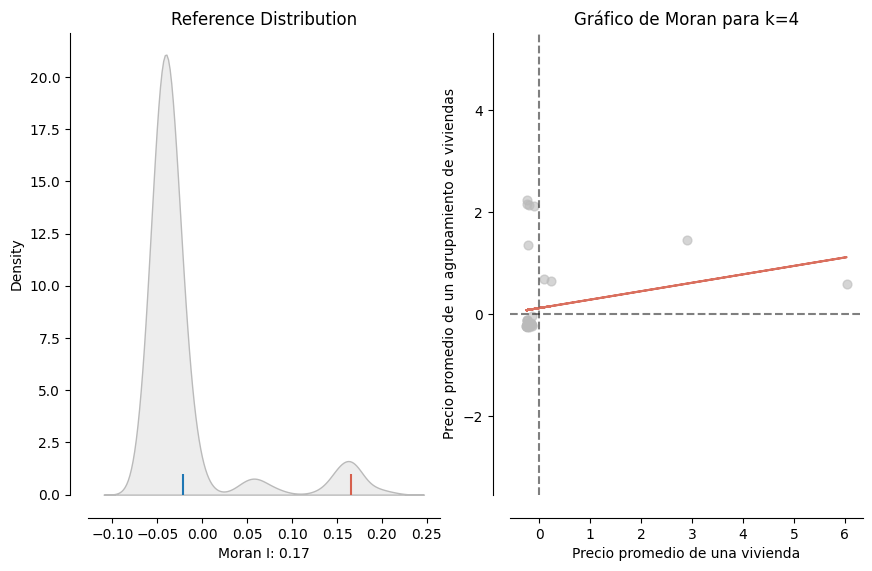

In [612]:
# Usamos el algoritmo del vecino más cercano promediando la distancia a los 4 más cercanos.
k_neighbors = 4
wq = libpysal.weights.KNN.from_dataframe(gdf_zipcodes, k=k_neighbors)

# Con esto, calculamos el promedio de los precios de la matriz de pesos, no la suma total de precios para un mismo ZIP CODE:
wq.transform = 'R'

# Calculamos la I de Moran Global
y = gdf_zipcodes['MEDIAN_SALE_PRICE']
moran = Moran(y, wq, permutations=9999) # Hacemos 10mil simulaciones con el método de Monte Carlo.

print(f"Análisis con k = {k_neighbors} vecinos más cercanos: \n")
print(f"Valor I de Moran: {moran.I}, Valor P: {moran.p_sim}")

if moran.p_sim < 0.05 and moran.I > 0:
    print("Existe una autocorrelación estadísticamente positiva entre los precios de las propiedades según su ZIP CODE")
else:
    print("Los puntos siguen una distribución aleatoria.")

plot_moran(moran, figsize=(10,6))
plt.title(f'Gráfico de Moran para k={k_neighbors}')
plt.xlabel('Precio promedio de una vivienda')
plt.ylabel('Precio promedio de un agrupamiento de viviendas')
plt.show()

Entonces, obtenidos resultados estadísticamente representativos, concluimos que nuestra hipótesis nula no es cierta, así que demostramos que hay agrupamiento espacial (clustering) de los puntos con sus atributos de precio, así que el precio no es aleatoriamente distribuido espacialmente en Manhattan.

Ahora, usamos osmnx para poder usar OpenStreetMap, la idea es descargar las vias peatonales de Manhattan, para así calcular la distancia de cada propiedad a la entrada del metro de NYC más cercana, y agregarla al dataset de propiedades como una nueva columna.

https://osmnx.readthedocs.io/en/stable/user-reference.html

In [613]:
# Verificamos que los CRS a trabajar estén en latitud/longitud (EPSG:4326):
print(f"CRS de propiedades: {gdf_properties.crs}")
print(f"CRS de estaciones de metro: {gdf_subway.crs}")

# Usamos network_type=walk para descargar la red peatonal, porque nos interesa llegar al subway caminando.
walk_map_NYC_OSMNX = ox.graph_from_place("Manhattan, New York City, USA", network_type='walk')

# Creamos los nodos más cercanos entre las propiedades y el mapa:
property_nodes = ox.distance.nearest_nodes(walk_map_NYC_OSMNX, X=gdf_properties.geometry.x, Y=gdf_properties.geometry.y)
subway_nodes = ox.distance.nearest_nodes(walk_map_NYC_OSMNX, X=gdf_subway.geometry.x, Y=gdf_subway.geometry.y) # Lo mismo, pero con subway entrances.

# Añadimos el nodo de la propiedad a la calle más cercano como un nuevo atributo del GDF de propiedades.
gdf_properties['nearest_node'] = property_nodes

# Para posteriormente evitar hacer cálculos con nodos repetidos, sacamos sólo los que son únicos:
unique_subway_nodes = set(subway_nodes)

print(gdf_properties[['ADDRESS', 'SALE PRICE', 'nearest_node']].head())
# Las unidades no aparecen, pero no importa porque las reemplazaremos en la siguiente celda.

CRS de propiedades: EPSG:4326
CRS de estaciones de metro: EPSG:4326
                 ADDRESS  SALE PRICE  nearest_node
2           234 E 7TH ST     5615000    8309479364
14  516 EAST 13TH STREET    11032000   11890166394
15  518 EAST 13TH STREET    11032000   11890166394
17  535 EAST 12TH STREET     6852805    8309479480
93           32 AVENUE A     5750000    7465411056


Aquí, usamos el algoritmo de búsqueda de caminos Dijkstra https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.multi_source_dijkstra_path_length.html. Al principio habíamos planteado el uso del algoritmo A*, pero éste último realiza la búsqueda entre cada nodo, lo que es computacionalmente muy costoso y tomaba mucho tiempo. El algoritmo Dijkstra, en cambio, recorre, para cada propiedad, los caminos hasta los nodos de una sola vez, así que hace un cálculo más complejo pero lo realiza todo de una sola vez, lo que es más rápido en este caso.

In [614]:
# Calculamos las distancias desde todas las estaciones del metro de NYC hacia sus nodos más cercanos.
# Entonces, se almacenarán las todos los nodos de Manhattan con la distancia de cada nodo al metro más cercano:
distances_from_subways = nx.multi_source_dijkstra_path_length(walk_map_NYC_OSMNX, sources=unique_subway_nodes, weight='length')

# Una vez obtenidas las distancias, hacemos un loop de cada una de ellas con .map y las agregamos a dist_real_subway
gdf_properties['dist_real_subway'] = gdf_properties['nearest_node'].map(distances_from_subways)

# Reemplazamos dist_real_subway con dist_real_subway en el GDF, y luego guardamos el archivo para cachear.
gdf_properties_dist_subway = gdf_properties.copy()
gdf_properties_dist_subway['dist_real_subway'] = gdf_properties['dist_real_subway']

gdf_properties_dist_subway['dist_real_subway'].fillna(-1, inplace=True) # En caso de errores, rellenamos vacios con -1

print(gdf_properties_dist_subway[['ADDRESS', 'SALE PRICE', 'dist_real_subway']].head(), '\n')

output_file = os.path.join(".", "datasets", "gdf_rollingsales_with_subway_dist.gpkg")
gdf_properties_dist_subway.to_file(output_file, driver='GPKG', layer='properties')
print(f"Nuevo GDF guardado como '{output_file}'")

                 ADDRESS  SALE PRICE  dist_real_subway
2           234 E 7TH ST     5615000        917.819963
14  516 EAST 13TH STREET    11032000        103.660931
15  518 EAST 13TH STREET    11032000        103.660931
17  535 EAST 12TH STREET     6852805        376.114007
93           32 AVENUE A     5750000        416.483166 

Nuevo GDF guardado como './datasets/gdf_rollingsales_with_subway_dist.gpkg'


Haremos lo mismo con el dataset de hospitales, calcularemos la distancia mínima de cada propiedad al hospital más cercano, y lo agregaremos como columna nueva al dataset.

In [615]:
# Verificamos los CRS de los nuevos datos a trabajar.
print(f"CRS de propiedades: {gdf_properties.crs}")
print(f"CRS de hospitales: {gdf_hospitals.crs}")

hospital_nodes = ox.distance.nearest_nodes(walk_map_NYC_OSMNX, X=gdf_hospitals.geometry.x, Y=gdf_hospitals.geometry.y)

# Para posteriormente evitar hacer cálculos con nodos repetidos, sacamos sólo los que son únicos.
unique_hospital_nodes = set(hospital_nodes)

print(f"Se calculará la distancia desde cada propiedad a {len(unique_hospital_nodes)} ubicaciones de hospitales únicos.")

CRS de propiedades: EPSG:4326
CRS de hospitales: EPSG:4326

Nodos de red más cercanos para hospitales identificados.
Se calculará la distancia desde cada propiedad a 40 ubicaciones de hospitales únicos.


In [616]:
# Calculamos las distancias desde todos los hospitales de NYC hacia sus nodos más cercanos.
# El resultado es un diccionario con todos los nodos de Manhattan y la distancia de cada uno al hospital más cercano.
distances_from_hospitals = nx.multi_source_dijkstra_path_length(walk_map_NYC_OSMNX, sources=unique_hospital_nodes, weight='length')

# Usamos el 'nearest_node' de cada propiedad que ya calculamos para buscar su distancia.
gdf_properties['dist_real_hospital'] = gdf_properties['nearest_node'].map(distances_from_hospitals)

gdf_properties_dist_hospital = gdf_properties.copy()
# Rellenamos vacíos con -1 en caso de errores o nodos aislados sin ruta conectada a las otras!!!
gdf_properties_dist_hospital['dist_real_hospital'].fillna(-1, inplace=True)

print("\nCálculo de distancias de red a hospitales finalizado.")
print(gdf_properties_dist_hospital[['ADDRESS', 'SALE PRICE', 'dist_real_hospital']].head(), '\n')

output_file_hospitals = os.path.join(".", "datasets", "gdf_rollingsales_with_hospital_dist.gpkg")
gdf_properties_dist_hospital.to_file(output_file_hospitals, driver='GPKG', layer='properties')
print(f"Nuevo GDF con distancias a hospitales guardado como '{output_file_hospitals}'")

Calculando distancias de red a hospitales...
Distancias desde cada nodo de la red al hospital más cercano calculadas.
Distancias a hospitales asignadas a cada propiedad.

Cálculo de distancias de red a hospitales finalizado.
                 ADDRESS  SALE PRICE  dist_real_hospital
2           234 E 7TH ST     5615000          862.526154
14  516 EAST 13TH STREET    11032000            0.000000
15  518 EAST 13TH STREET    11032000            0.000000
17  535 EAST 12TH STREET     6852805          274.743026
93           32 AVENUE A     5750000          771.862036 

Nuevo GDF con distancias a hospitales guardado como './datasets/gdf_rollingsales_with_hospital_dist.gpkg'


Hacemos otra columna más para las distancias más cercanas a los centros educativos.

In [617]:
from tqdm.auto import tqdm
import networkx as nx

# Verificamos los CRS de los nuevos datos a trabajar.
print(f"CRS de propiedades: {gdf_properties.crs}")
print(f"CRS de universidades: {gdf_universities.crs}")

university_nodes = ox.distance.nearest_nodes(walk_map_NYC_OSMNX, X=gdf_universities.geometry.x, Y=gdf_universities.geometry.y)

# Para posteriormente evitar hacer cálculos con nodos repetidos, sacamos sólo los que son únicos.
unique_university_nodes = set(university_nodes)

print("\nNodos de red más cercanos para universidades identificados.")
print(f"Se calculará la distancia desde cada propiedad a {len(unique_university_nodes)} ubicaciones de universidades únicas.")

CRS de propiedades: EPSG:4326
CRS de universidades: EPSG:4326

Nodos de red más cercanos para universidades identificados.
Se calculará la distancia desde cada propiedad a 62 ubicaciones de universidades únicas.


In [618]:
# Calculamos las distancias desde todas las universidades de NYC hacia sus nodos más cercanos.
distances_from_universities = nx.multi_source_dijkstra_path_length(walk_map_NYC_OSMNX, sources=unique_university_nodes, weight='length')
print("Distancias desde cada nodo de la red a la universidad más cercana calculadas.")

# Usamos el 'nearest_node' de cada propiedad para buscar su distancia en el diccionario.
gdf_properties['dist_real_university'] = gdf_properties['nearest_node'].map(distances_from_universities))
gdf_properties_dist_university = gdf_properties.copy()

# Rellenamos vacíos con -1 en caso de errores o nodos aislados sin ruta conectada a las otras!!!
gdf_properties_dist_university['dist_real_university'].fillna(-1, inplace=True)

print("Ya tenemos el cálculo de distancias de red a universidades!")
print(gdf_properties_dist_university[['ADDRESS', 'SALE PRICE', 'dist_real_university']].head(), '\n')

output_file_universities = os.path.join(".", "datasets", "gdf_rollingsales_with_university_dist.gpkg")
gdf_properties_dist_university.to_file(output_file_universities, driver='GPKG', layer='properties')
print(f"Nuevo GDF con distancias a universidades guardado como '{output_file_universities}'")

Calculando distancias de red a universidades...
Distancias desde cada nodo de la red a la universidad más cercana calculadas.
Distancias a universidades asignadas a cada propiedad.
Ya tenemos el cálculo de distancias de red a universidades!
                 ADDRESS  SALE PRICE  dist_real_university
2           234 E 7TH ST     5615000            918.999398
14  516 EAST 13TH STREET    11032000           1111.527996
15  518 EAST 13TH STREET    11032000           1111.527996
17  535 EAST 12TH STREET     6852805           1324.965527
93           32 AVENUE A     5750000            820.902642 

Nuevo GDF con distancias a universidades guardado como './datasets/gdf_rollingsales_with_university_dist.gpkg'


Ahora, sabemos que tenemos el ndvi calculado anteriormente en la variable ndvi_image, así que lo utilizamos para poder calcular el área en metros cuadrados de vegetación presente en cada pixel. La idea es, teniendo el procesado del raster en un nuevo GDF, unirlo con el gdf_properties, y agregar el área verde en cierto RADIUS_M alrededor de cada propiedad, como una nueva columna del GDF.

In [619]:
RADIUS_M = 1000 # Radio circular en metros.
THRESHOLD = 0.3 # Aproximadamente
CRS_METERS = "EPSG:32118" # CRS Para metros en NYC utilizado en todo el proyecto.

#ndvi = s2_image_median.normalizedDifference(['B8', 'B4']).rename('NDVI') # Ya definido arriba!

# Obtenemos los puntos de vegetación a partir del raster ndvi calculado
vegetation_mask = ndvi_image.gt(THRESHOLD) # ndvi_image está calculado en celdas anteriores.
vegetation_points = vegetation_mask

vegetation_points = vegetation_mask.updateMask(vegetation_mask).sample(
    region=manhattan_ee, # Lo aplicamos solo al area de Manhattan definida al inicio.
    scale=10,
    geometries=True
)

# Pasamos todos los puntos a un GDF, para luego poder hacer un join con el GDF de propiedades:
gdf_vegetation = geemap.ee_to_gdf(vegetation_points)

# Calculamos el área verde para cada propiedad del GDF de propiedades, en un radio de RADIUS_M metros.
print(f"Calculando área verde en un radio de {RADIUS_M}m para cada propiedad...")
properties_proj = gdf_properties.to_crs(CRS_METERS)
vegetation_proj = gdf_vegetation.to_crs(CRS_METERS)

property_buffers = properties_proj.copy()
property_buffers['geometry'] = property_buffers.geometry.buffer(RADIUS_M)

join_result = gpd.sjoin(vegetation_proj, property_buffers, how="inner", predicate="within")
green_points_count = join_result.groupby('index_right').size()

# Calculamos el area de cada punto del raster:
pixel_area_m2 = 100 # Cada pixel tiene resolución de 10m, así que el área al cuadrado es 10m x 10m = 100m^2
green_area = green_points_count * pixel_area_m2
green_area.name = 'green_area_in_radius' # El nombre que tendra la columna nueva de cada propiedad.

# Para evitar errores, si la celda ya ha sido ejecutada y quremos probar nuevamente, debemos
# eliminarla para volver a calcular todo, para eliminarlo de la memoria temporal del ámbito de ejecución
# de Google Colab, ya que hemos tenido problemas sin este condicional:
if 'green_area_in_radius' in gdf_properties.columns:
    gdf_properties = gdf_properties.drop(columns=['green_area_in_radius'])

# Hacemos un join de el area verde calculada para cada pixel en un raster, con el GDF principal.
gdf_properties = gdf_properties.join(green_area).fillna(0) # Rellenamos areas sin nada con 0
# Parseo a entero para evitar errores en el modelo predictivo posterior:
gdf_properties['green_area_in_radius'] = gdf_properties['green_area_in_radius'].astype(int)

display(gdf_properties[['ADDRESS', 'SALE PRICE', 'green_area_in_radius']].head()) # Comprobamos que se haya calculado bien

Calculando área verde en un radio de 1000m para cada propiedad...


,ADDRESS,SALE PRICE,green_area_in_radius
2,234 E 7TH ST,5615000,712800
14,516 EAST 13TH STREET,11032000,711000
15,518 EAST 13TH STREET,11032000,713700
17,535 EAST 12TH STREET,6852805,729600
93,32 AVENUE A,5750000,761300


Una vez calculadas las áreas para cada pixel y guardados en el gdf_vegetation, hacemos la proyección adecuada en metros para cada dataset, y hacemos el cálculo para cada pixel por separado, y contamos cuánta área hay en un radio de RADIUS_M metros para cada propiedad. Finalmente, el área obtenida se agrega como una nueva columna del GDF de propiedades.

In [620]:
# Creamos un buffer de 500metros para cada propiedad y realizamos un spatial join para guardar esos datos.
print(f"Calculando área verde en un radio de {RADIUS_M}m para cada propiedad...")
property_buffers = properties_proj.copy()
property_buffers['geometry'] = property_buffers.geometry.buffer(RADIUS_M)
join_result = gpd.sjoin(vegetation_proj, property_buffers, how="inner", predicate="within")

# Hacemos el cálculo de la cantidad de área verde por pixel
green_points_count = join_result.groupby('index_right').size()
pixel_area_m2 = 100 # Cada punto representa un píxel de 10m x 10m
green_area = green_points_count * pixel_area_m2
green_area.name = 'green_area_in_radius'

# Para evitar errores, si la celda ya ha sido ejecutada y quremos probar nuevamente, debemos
# eliminarla para volver a calcular todo, para eliminarlo de la memoria temporal del ámbito de ejecución
# de Google Colab, ya que hemos tenido problemas sin este condicional:
if 'green_area_in_radius' in gdf_properties.columns:
    gdf_properties = gdf_properties.drop(columns=['green_area_in_radius'])

# Hacemos un join de el area verde calculada para cada pixel en un raster, con el GDF principal.
gdf_properties = gdf_properties.join(green_area).fillna(0) # Rellenamos areas sin nada con 0
# Parseo a entero para evitar errores en el modelo predictivo posterior:
gdf_properties['green_area_in_radius'] = gdf_properties['green_area_in_radius'].astype(int)

# Comprobamos que se haya calculado bien en el GDF principal
display(gdf_properties[['ADDRESS', 'SALE PRICE', 'green_area_in_radius']].head())

Calculando área verde en un radio de 1000m para cada propiedad...


,ADDRESS,SALE PRICE,green_area_in_radius
2,234 E 7TH ST,5615000,712800
14,516 EAST 13TH STREET,11032000,711000
15,518 EAST 13TH STREET,11032000,713700
17,535 EAST 12TH STREET,6852805,729600
93,32 AVENUE A,5750000,761300


Las distancias calculadas están en metros, gracias al CRS utilizado.

Como vemos aquí abajo, el dataset gdf_properties ahora tiene las distancias al subway, hospital y centro educativo más cercano, en las columnas dist_real_subway y dist_real_hospital, dist_real_university respectivamente, además del green_area_in_radius.

En celdas posteriores sólo nos falta agregar una nueva columna al GDF de propiedades, que contendrá la cantidad de inundaciones que han ocurrido en el periodo de estudio, según los dos casos que se presentarán más abajo.

In [621]:
print(gdf_properties.columns) # Miramos el gdf properties, solo sus columnas

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASEMENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'LATITUDE', 'LONGITUDE', 'GEOCODING_STATUS',
       'geometry', 'nearest_node', 'dist_real_subway', 'dist_real_hospital',
       'dist_real_university', 'green_area_in_radius'],
      dtype='object')


Ahora, formaremos una segmentación de los datos, representaremos mediante hexágonos de colores el precio promedio de las casas que están en esa área aproximada, usaremos h3 (https://h3geo.org/) para poder crear fácilmente los hexágonos, la idea es crear la propiedad "hex_id" en el GDF de propiedades, con las coordenadas, para luego poder usar eso como agrupamiento, esto es, agrupar según el hex_id, y calcular el precio promedio y la cantidad de viviendas o propiedades que caen dentro de ese hexágono.

In [622]:
# h3 requiere coordenadas en latitud/longitud, por lo que nos aseguramos de tener el CRS correcto (EPSG:4326)
print(f"CRS de propiedades: {gdf_properties.crs}")

# Asignamos cada vivienda a un hexágono
gdf_properties['hex_id'] = gdf_properties.apply(
    lambda row: h3.latlng_to_cell(row.geometry.y, row.geometry.x, 8),
    axis=1
)

# usamos .groupby para agrupar las viviendas que pertenecen a un mismo hexágono, y luego con
# .agg hacemos un agregado donde calculamos el avg_price y la cantidad de propiedades en ese hexágono:
hex_aggregated = gdf_properties.groupby('hex_id').agg(
    avg_price=('SALE PRICE', 'mean'),
    property_count=('SALE PRICE', 'size')
).reset_index() # Reseteamos el índice del nuevo GDF porque hubieron cambios importantes.

# Hacemos un filtro de n propiedades mínimas que deben existir en cada hexágono:
min_properties = 4
hex_aggregated_filtered = hex_aggregated[hex_aggregated['property_count'] >= min_properties]

# En base a cada id de un hexágono, esta función generará un polígono, que será la geometría del hexágono:
# def hex_id_to_polygon(hex_id):
#     points = h3.cell_to_boundary(hex_id, unit='deg')
#     return Polygon(points)
def hex_id_to_polygon(hex_id):
    # CORRECCIÓN AQUÍ:
    # 1. Se elimina el parámetro 'unit', ya que ahora no es necesario.
    # 2. La nueva función devuelve tuplas (lat, lon), pero Polygon necesita (lon, lat),
    #    así que invertimos el orden de cada tupla en la lista.
    points_lat_lon = h3.cell_to_boundary(hex_id)
    points_lon_lat = [(lon, lat) for lat, lon in points_lat_lon]
    return Polygon(points_lon_lat)

# Usamos la función, para cada vivienda del GDF, pasamos el hex_id por la función y agregamos el resultado como geometry.
hex_aggregated_filtered['geometry'] = hex_aggregated_filtered['hex_id'].apply(hex_id_to_polygon)


# --- Código de popup generado con AI ---
# Preparación para los popups
properties_for_popup = gdf_properties.merge(hex_aggregated_filtered[['hex_id']], on='hex_id', how='inner')

def create_popup_html(group):
    html = f"<b>Propiedades en esta zona: {len(group)}</b><br><ul>"
    for _, row in group.head(10).iterrows():
        price_formatted = f"${row['SALE PRICE']:,.0f}"
        html += f"<li>{row['ADDRESS']}: {price_formatted}</li>"
    if len(group) > 10:
        html += f"<li>... y {len(group) - 10} más.</li>"
    html += "</ul>"
    return html

popup_data = properties_for_popup.groupby('hex_id').apply(create_popup_html)
popup_data.name = 'popup_html'
hex_aggregated_filtered = hex_aggregated_filtered.merge(popup_data, on='hex_id', how='left')

print(f"GeoDataFrame final con {len(hex_aggregated_filtered)} hexágonos")
hex_aggregated_filtered.head()

CRS de propiedades: EPSG:4326
GeoDataFrame final con 71 hexágonos


,hex_id,avg_price,property_count,geometry,popup_html
0,882a100881fffff,8.298930e+06,21,POLYGON ((-73.97278336829461 40.80228501542363...,<b>Propiedades en esta zona: 21</b><br><ul><li...
1,882a100883fffff,3.212652e+06,41,POLYGON ((-73.97033476270241 40.79441462668289...,<b>Propiedades en esta zona: 41</b><br><ul><li...
2,882a100887fffff,1.223875e+06,4,POLYGON ((-73.98113799492529 40.79676915631967...,<b>Propiedades en esta zona: 4</b><br><ul><li>...
3,882a100889fffff,4.167833e+06,9,POLYGON ((-73.96442683242793 40.80780061538989...,<b>Propiedades en esta zona: 9</b><br><ul><li>...
4,882a10088bfffff,2.880401e+06,15,POLYGON ((-73.96197935638261 40.79992952883273...,<b>Propiedades en esta zona: 15</b><br><ul><li...


Una vez calculado todo, creamos un folium para poder poner los hexágonos en la visualización.

In [623]:
# Creamos un folium centrado en Manhattan, para poder ver mejor los hexágonos
map_final = folium.Map(location=[40.78, -73.96], zoom_start=12, tiles="CartoDB positron")

# Según el precio min y max, creamos los valores max y min del mapa de colores.
min_price = hex_aggregated_filtered['avg_price'].min()
max_price = hex_aggregated_filtered['avg_price'].max()
colormap = linear.Reds_09.scale(min_price, max_price)

# --- Código de popup generado con AI ---
# Iteración por cada entrada del dataset para agregar el hexágono con su color al folium.
for _, row in hex_aggregated_filtered.iterrows():
    geojson_layer = folium.GeoJson(
        row.geometry.__geo_interface__,
        style_function=lambda feature, color=colormap(row['avg_price']): {
            'color': 'black',
            'weight': 0.5,
            'fillColor': color,
            'fillOpacity': 0.8,
        }
    )
    popup = folium.Popup(row['popup_html'], max_width=400)
    popup.add_to(geojson_layer)
    geojson_layer.add_to(map_final)

# --- Código de popup generado con AI ---
legend_title = 'Precio Promedio ($)'
legend_html = f'''
     <div style="
     position: fixed;
     bottom: 50px;
     right: 50px;
     width: 150px;
     height: auto;
     border:2px solid grey;
     z-index:9999;
     font-size:14px;
     background-color:white;
     padding: 10px;
     ">
     <b>{legend_title}</b><br>
     '''

# --- Código de popup generado con AI ---
# Iteramos sobre 6 pasos en nuestra escala de colores para crear las etiquetas, una por cada color.
for val in np.linspace(colormap.vmin, colormap.vmax, 6):
    color = colormap(val)
    val_formatted = f"${val:,.0f}"
    legend_html += f'<i class="fa fa-circle" style="color:{color}"></i>&nbsp;{val_formatted}<br>'

legend_html += '</div>'
map_final.get_root().html.add_child(folium.Element(legend_html))

display(map_final)

Creamos un buffer (utilizado en las primeras ayudantías) https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html de 500 metros, para poder ver cuántos tiroteos han ocurrido cerca de cada propiedad.

In [624]:
radius_m = 500 # radio de metros para buscar incidentes
CRS_METERS = "EPSG:32118" # Definimos el CRS para trabajar en metros en NYC

# Hacemos copias para no alterar la proyección de los GDF originales.
properties_to_analyze = gdf_properties.copy()
shootings_to_analyze = gdf_incidents.copy()

# Proyectamos al CRS en metros (EPSG:32118 para NYC)
properties_proj = properties_to_analyze.to_crs(CRS_METERS)
shootings_proj = shootings_to_analyze.to_crs(CRS_METERS)

# Creamos un buffer que rodee a cada propiedad, de radius_m metros de medida:
property_with_buffer = properties_proj.copy()
property_with_buffer['geometry'] = property_with_buffer.geometry.buffer(radius_m)

# Hacemos un SPATIAL JOIN del GDF que contiene los tiroteos con el de las propiedades con el buffer.
join_result = gpd.sjoin(shootings_proj, property_with_buffer, how="inner", predicate="within")

# Contamos la cantidad de tiroteos que caen en cada propiedad con el buffer.
shootings_count = join_result.groupby('index_right').size()
shootings_count.name = 'shootings_in_radius'

# Para evitar errores, si la celda ya ha sido ejecutada y quremos probar nuevamente, debemos
# eliminarla para volver a calcular todo, para eliminarlo de la memoria temporal del ámbito de ejecución
# de Google Colab, ya que hemos tenido problemas sin este condicional:
if 'shootings_in_radius' in gdf_properties.columns:
    gdf_properties = gdf_properties.drop(columns=['shootings_in_radius'])

# Hacemos un join de los datos del conteo de tiroteos con los datos del GDF principal
# Como limpieza, si no hay tiroteos en una propiedad, le ponemos 0 y lo convertimos a tipo int
gdf_properties = gdf_properties.join(shootings_count).fillna(0)
# Como limpieza, convertimos la nueva columna a tipo entero.
gdf_properties['shootings_in_radius'] = gdf_properties['shootings_in_radius'].astype(int) # Parseo necesario

# Verificamos y mostramos para confirmar que todo esté bien
propiedades_con_tiroteos = gdf_properties[gdf_properties['shootings_in_radius'] > 0].shape[0]
print(f"Hay {propiedades_con_tiroteos} propiedades con 1 o más tiroteos en un radio de {radius_m} metros.")

display(gdf_properties[['ADDRESS', 'SALE PRICE', 'shootings_in_radius']].head())

Hay 990 propiedades con 1 o más tiroteos en un radio de 500 metros.


,ADDRESS,SALE PRICE,shootings_in_radius
2,234 E 7TH ST,5615000,12
14,516 EAST 13TH STREET,11032000,10
15,518 EAST 13TH STREET,11032000,10
17,535 EAST 12TH STREET,6852805,10
93,32 AVENUE A,5750000,12


Luego, hacemos lo mismo que en celdas previas para los hexágonos con precios de propiedades, pero en vez del precio, ahora usamos la cantidad de tiroteos, el código es casi totalmente copiar y pegar la lógica previa.

In [625]:
# h3 requiere coordenadas en latitud/longitud.
gdf_incidents_h3 = gdf_incidents.to_crs("EPSG:4326")
# También necesitamos las propiedades para los popups.
gdf_properties_h3 = gdf_properties.to_crs("EPSG:4326")

resolution = 8
gdf_incidents_h3['hex_id'] = gdf_incidents_h3.apply(
    lambda row: h3.latlng_to_cell(row.geometry.y, row.geometry.x, resolution), axis=1
)

# Contar los tiroteos por hexágono
shooting_counts = gdf_incidents_h3.groupby('hex_id').size().reset_index(name='shooting_count')

# GDF de Hexágonos con los Conteos
def hex_id_to_polygon(hex_id):
    pts_lat_long = h3.cell_to_boundary(hex_id)
    points_lon_lat = [(lon, lat) for lat, lon in pts_lat_long] # Cambiamos el orden para poder proyectar.
    return Polygon(points_lon_lat)

# Creamos las geometrías y el GeoDataFrame base
shooting_counts['geometry'] = shooting_counts['hex_id'].apply(hex_id_to_polygon)
gdf_hexagons_shootings = gpd.GeoDataFrame(shooting_counts, crs="EPSG:4326")

# Asignamos también las propiedades a los hexágonos para los popups
gdf_properties_h3['hex_id'] = gdf_properties_h3.apply(
    lambda row: h3.latlng_to_cell(row.geometry.y, row.geometry.x, resolution), axis=1
)

# Unimos para saber qué propiedades están en los hexágonos con tiroteos
properties_for_popup = gdf_properties_h3.merge(gdf_hexagons_shootings[['hex_id']], on='hex_id', how='inner')

# --- Código de popup generado con AI ---
def create_popup_html(group):
    html = f"<b>Propiedades en esta zona de riesgo: {len(group)}</b><br><ul>"
    for _, row in group.head(10).iterrows():
        price_formatted = f"${row['SALE PRICE']:,.0f}"
        html += f"<li>{row['ADDRESS']}: {price_formatted}</li>"
    if len(group) > 10:
        html += f"<li>... y {len(group) - 10} más.</li>"
    html += "</ul>"
    return html

popup_data = properties_for_popup.groupby('hex_id').apply(create_popup_html)
popup_data.name = 'popup_html'
# Unimos los popups al GDF de hexágonos de tiroteos
gdf_hexagons_shootings = gdf_hexagons_shootings.merge(popup_data, on='hex_id', how='left')
gdf_hexagons_shootings['popup_html'].fillna("No hay propiedades registradas en esta zona.", inplace=True)

Representamos en un folium las zonas hexagonales, con su cantidad de tiroteos indicada en la leyenda y los popups.

In [626]:
# Mapa folium centrado en Manhattan, como antes.
map_shootings = folium.Map(location=[40.78, -73.96], zoom_start=12, tiles="CartoDB positron")

# Creamos la misma paleta que antes, con min y max segun cantidad de incidentes.
min_count = gdf_hexagons_shootings['shooting_count'].min()
max_count = gdf_hexagons_shootings['shooting_count'].max()
colormap = linear.YlOrRd_09.scale(min_count, max_count)

# Agregamos cada hexágono al folium
for _, row in gdf_hexagons_shootings.iterrows():
    geojson_layer = folium.GeoJson(
        row.geometry.__geo_interface__,
        # El color ahora depende de la cantidad de tiroteos, hay una paleta.
        style_function=lambda feature, color=colormap(row['shooting_count']): {
            'color': 'black',
            'weight': 0.5,
            'fillColor': color,
            'fillOpacity': 0.8,
        }
    )
    # El popup muestra la lista de propiedades en esa zona
    popup = folium.Popup(row['popup_html'], max_width=400)
    popup.add_to(geojson_layer)
    geojson_layer.add_to(map_shootings)

# --- Código de popup generado con AI ---
legend_title = 'Cantidad de tiroteos en la zona'
legend_html = f'''
     <div style="
     position: fixed; bottom: 50px; right: 50px; width: 150px; height: auto;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;">
     <b>{legend_title}</b><br>
     '''
for val in np.linspace(colormap.vmin, colormap.vmax, 6):
    color = colormap(val)
    # Formateamos el número como un entero
    val_formatted = f"{int(val)}"
    legend_html += f'<i class="fa fa-circle" style="color:{color}"></i>&nbsp;{val_formatted}<br>'
legend_html += '</div>'
map_shootings.get_root().html.add_child(folium.Element(legend_html))

display(map_shootings)

A continuación, se presentan dos casos de inundaciones en la isla de Manhattan, ocurridos en el 2023 y 2024, se han utilizado datos SAR y el dataset de Sentinel-1:

In [627]:
# Función que transforma en dB
# Según la propia página de Sentinel 1 GRD:
# "se convierten en decibeles mediante la escala de registro (10*log10(x))."
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD?hl=es-419

def dB_VV(img):
    return img.select('VV').log10().multiply(10)

## Caso 2023:

Durante el 29 de septiembre de 2023, el servicio meteorológico nacional emitió un aviso de inundación repentina para gran parte de la región, lo que afectó a 8,5 millones de personas.

Este suceso fue tan potente que la gobernadora de New York, Kathy Hochul, declaró el “estado de emergencia” para Nueva York. Con respecto al distrito de Manhattan, se pudieron evidenciar autos varados por las inundaciones. Entonces es interesante revisarlo para nuestro estudio.


- 29 de Septiembre de 2023
- https://www.lanacion.com.ar/estados-unidos/las-intensas-lluvias-provocan-inundaciones-repentinas-en-nueva-york-e-interrupciones-de-servicios-nid29092023/

In [636]:
# Aquí se usa el código extraído de "floodMapping_Maule.ipynb".
pre_flood_start_date = '2023-09-25'
pre_flood_end_date = '2023-09-28'
flood_start_date = '2023-09-29'
flood_end_date = '2023-10-09'

s1_col_pre = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    .filterDate(pre_flood_start_date, pre_flood_end_date)
    .filterBounds(manhattan_ee)
    .select('VV'))


s1_col_post= (ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    .filterDate(flood_start_date, flood_end_date)
    .filterBounds(manhattan_ee)
    .select('VV'))

if s1_col_pre.size().getInfo() > 0 and s1_col_post.size().getInfo() > 0: #Verificamos que la colección tenga imágenes
    s1_col_pre = s1_col_pre.map(dB_VV)
    s1_col_post = s1_col_post.map(dB_VV)

    sar_pre = s1_col_pre.reduce(ee.Reducer.percentile([20]))
    sar_post = s1_col_post.reduce(ee.Reducer.percentile([20]))

    threshold = -17

    sar_pre_filtered = sar_pre.focal_median(radius=1, units='pixels')
    sar_post_filtered = sar_post.focal_median(radius=1, units='pixels')

    water_pre = sar_pre_filtered.lt(threshold)
    water_post = sar_post_filtered.lt(threshold)

    flood_extent = water_post.unmask().subtract(water_pre.unmask()).gt(0).selfMask()

    flood_points = flood_extent.sample(
        region=manhattan_ee,
        scale=10,
        projection='EPSG:4326',
        geometries=True
    )

    # Lo convertimos en gdf:
    gdf_fp_23 = geemap.ee_to_gdf(flood_points)

    area = flood_extent.reduceRegion(
        reducer= ee.Reducer.sum(),
        geometry= manhattan_ee,
        scale= 10,
        bestEffort= True
    )

    area = area.getInfo()

    print(f"El área inundada es de {str(area['VV_p20'] * 100)} m^2")

    Map.addLayer(sar_pre.clip(manhattan_ee), {'min': -25, 'max': -5}, 'SAR pre')
    Map.addLayer(sar_post.clip(manhattan_ee), {'min': -25, 'max': -5}, 'SAR post')

    Map.addLayer(flood_extent.clip(manhattan_ee), {'palette': 'magenta'}, 'Flood Extent')
    Map.addLayer(flood_points, {'color': 'blue'}, 'Flood Points 2023')

    Map.addLayerControl()
    Map

else:
    print("No se han hallado imagenes para el dataset en las fechas de interés.")

display(Map)

El área inundada es de 144156.07843137253 m^2


Map(center=[40.7, -74.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

## Caso 2024

Durante el 6 de Agosto de 2024, el usuario "Mayor Eric Adams" dio a conocer el siguiente mensaje: "Neoyorquinos: se pronostican lluvias intensas para esta noche. Hay una alerta de inundaciones y una advertencia de viaje vigentes hasta mañana el mediodía por tormentas eléctricas. Tenga un plan para estar protegido."

Estas lluvias intensas que menciona fueron tan severas que provocaron inundaciones por gran parte de la zona, por ende, es ideal para poder revisar como podrían afectar las inundaciones a Manhattan.

- Fecha: 6 de Agosto de 2024
- Enlace: https://spectrumnoticias.com/ny/nyc/noticias/2024/08/06/ha-comenzado-la-lluvia--advierten-de-posibles-inundaciones--advertencia-de-viaje-por-tormentas-electricas

In [628]:
Map = geemap.Map(center=[40.7, -74.0], zoom=12) #Definimos el mapa y centro

# Aquí se usa el código extraído de "floodMapping_Maule.ipynb".
pre_flood_start_date = '2024-08-03'
pre_flood_end_date = '2024-08-05'
flood_start_date = '2024-08-06'
flood_end_date = '2024-08-16'

s1_col_pre = (
    ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    .filterDate(pre_flood_start_date, pre_flood_end_date)
    .filterBounds(manhattan_ee)
    .select('VV'))


s1_col_post= (ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
    .filterDate(flood_start_date, flood_end_date)
    .filterBounds(manhattan_ee)
    .select('VV'))

if s1_col_pre.size().getInfo() > 0 and s1_col_post.size().getInfo() > 0: #Verificamos que la colección tenga imágenes
    s1_col_pre = s1_col_pre.map(dB_VV)
    s1_col_post = s1_col_post.map(dB_VV)

    sar_pre = s1_col_pre.reduce(ee.Reducer.percentile([20]))
    sar_post = s1_col_post.reduce(ee.Reducer.percentile([20]))

    threshold = -17

    sar_pre_filtered = sar_pre.focal_median(radius=1, units='pixels')
    sar_post_filtered = sar_post.focal_median(radius=1, units='pixels')

    water_pre = sar_pre_filtered.lt(threshold)
    water_post = sar_post_filtered.lt(threshold)

    flood_extent = water_post.unmask().subtract(water_pre.unmask()).gt(0).selfMask()

    flood_points = flood_extent.sample(
        region=manhattan_ee,
        scale=10,
        projection='EPSG:4326',
        geometries=True
    )

    # Lo convertimos en gdf:
    gdf_fp_24 = geemap.ee_to_gdf(flood_points)

    area = flood_extent.reduceRegion(
        reducer= ee.Reducer.sum(),
        geometry= manhattan_ee,
        scale= 10,
        bestEffort= True
    )

    area = area.getInfo()

    print(f"El área inundada es de {str(area['VV_p20'] * 100)} m^2")

    Map.addLayer(sar_pre.clip(manhattan_ee), {'min': -25, 'max': -5}, 'SAR pre')
    Map.addLayer(sar_post.clip(manhattan_ee), {'min': -25, 'max': -5}, 'SAR post')

    Map.addLayer(flood_extent.clip(manhattan_ee), {'palette': 'magenta'}, 'Flood Extent')
    Map.addLayer(flood_points, {'color': 'red'}, 'Flood Points 2024')

    Map.addLayerControl()
    Map

else:
    print("No se han hallado imagenes para el dataset en las fechas de interés.")

display(Map)

El área inundada es de 148410.19607843136 m^2


Map(center=[40.7, -74.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI…

### Revisando ambos casos

Decidimos revisar ambos casos en conjunto para poder manipular tan sólo un geodataframe y ver comportamientos que se podrían llegar a repetir con respecto a las inundaciones. Por ejemplo: ¿habrá alguna zona que NO suele tener inundaciones, o suele tener menos?

La respuesta a esta pregunta podría ser efectiva para ver si afecta realmente al precio de las viviendas, lo que ha sido estudiado con el modelo de predicción.

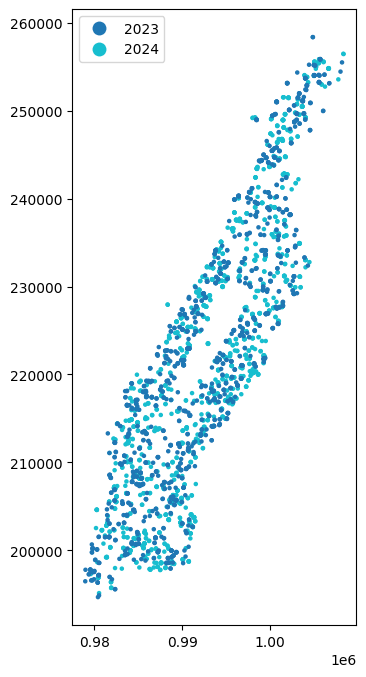

In [637]:
gdf_fp_23['year'] = '2023'
gdf_fp_24['year'] = '2024'

gdf = gpd.GeoDataFrame(pd.concat([gdf_fp_24, gdf_fp_23], ignore_index=True))

gdf = gdf.to_crs(epsg=2263) # Proyección en metros para NYC.

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(ax=ax, column='year', categorical=True, markersize=5, legend=True)
plt.show()

coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

db = DBSCAN(eps=328.084, min_samples=3).fit(coords)
gdf['cluster'] = db.labels_

# No nos interesa mostrar el clustering, esto es sólo para probar
# fig, ax = plt.subplots(figsize=(8, 8))
# gdf.plot(ax=ax, column='cluster', categorical=True, markersize=5, legend=False)
# plt.show()

### Segmentación hexagonal aplicada al análisis de inundaciones

Como podemos ver, la segmentación hexagonal resultó una herramienta fundamental para visualizar de forma clara y detallada las zonas con mayor propensión a inundarse, al menos en el perido de estudio. Este tipo de representación espacial no solo mejora significativamente el atractivo visual del análisis en la presentación, sino que también aporta un gran valor informativo al facilitar la interpretación de patrones en los puntos. A través de una escala cromática con la paleta de ccolores, se identifican las áreas que presentaron signos de inundación según los datos obtenidos por el dataset Sentinel-1 en las dos fechas en que se registraron los eventos (2023 y 2024).

In [638]:
# h3 requiere coordenadas en latitud/longitud.
gdf_flood_h3 = gdf.to_crs("EPSG:4326")
# También necesitamos las propiedades para los popups.
gdf_properties_h3 = gdf_properties.to_crs("EPSG:4326")

resolution = 8
gdf_flood_h3['hex_id'] = gdf_flood_h3.geometry.apply(
    lambda geom: h3.latlng_to_cell(geom.centroid.y, geom.centroid.x, resolution)
)

# Contar los tiroteos por hexágono
flood_counts = gdf_flood_h3.groupby('hex_id').size().reset_index(name='flood_count')

# GDF de Hexágonos con los Conteos
def hex_id_to_polygon(hex_id):
    latlngs = h3.cell_to_boundary(hex_id)
    points = [(lng, lat) for lat, lng in latlngs]
    return Polygon(points)

# Creamos las geometrías y el GeoDataFrame base
flood_counts['geometry'] = flood_counts['hex_id'].apply(hex_id_to_polygon)
gdf_hexagons_flood = gpd.GeoDataFrame(flood_counts, crs="EPSG:4326")

# --- Código de popup generado con AI ---
# Asignamos también las propiedades a los hexágonos para los popups
gdf_properties_h3['hex_id'] = gdf_properties_h3.geometry.apply(
    lambda geom: h3.latlng_to_cell(geom.y, geom.x, resolution)
)

# Unimos para saber qué propiedades están en los hexágonos con tiroteos
properties_for_popup = gdf_properties_h3.merge(gdf_hexagons_flood[['hex_id']], on='hex_id', how='inner')

def create_popup_html(group):
    html = f"<b>Propiedades en esta zona de riesgo: {len(group)}</b><br><ul>"
    for _, row in group.head(10).iterrows():
        price_formatted = f"${row['SALE PRICE']:,.0f}"
        html += f"<li>{row['ADDRESS']}: {price_formatted}</li>"
    if len(group) > 10:
        html += f"<li>... y {len(group) - 10} más.</li>"
    html += "</ul>"
    return html

popup_data = properties_for_popup.groupby('hex_id').apply(create_popup_html)
popup_data.name = 'popup_html'
# Unimos los popups al GDF de hexágonos de tiroteos
gdf_hexagons_flood = gdf_hexagons_flood.merge(popup_data, on='hex_id', how='left')
gdf_hexagons_flood['popup_html'].fillna("No hay propiedades registradas en esta zona.", inplace=True)
# Mapa folium centrado en Manhattan, como antes.
map_flood = folium.Map(location=[40.78, -73.96], zoom_start=12, tiles="CartoDB positron")

# Creamos la misma paleta que antes, con min y max segun cantidad de incidentes.
min_count = gdf_hexagons_flood['flood_count'].min()
max_count = gdf_hexagons_flood['flood_count'].max()
colormap = linear.Blues_09.scale(min_count, max_count)

# Agregamos cada hexágono al folium
for _, row in gdf_hexagons_flood.iterrows():
    geojson_layer = folium.GeoJson(
        row.geometry.__geo_interface__,
        # El color ahora depende de la cantidad de tiroteos, hay una paleta.
        style_function=lambda feature, color=colormap(row['flood_count']): {
            'color': 'black',
            'weight': 0.5,
            'fillColor': color,
            'fillOpacity': 0.8,
        }
    )
    # El popup muestra la lista de propiedades en esa zona
    popup = folium.Popup(row['popup_html'], max_width=400)
    popup.add_to(geojson_layer)
    geojson_layer.add_to(map_flood)

# --- Código de popup generado con AI ---
legend_title = 'Cantidad de Inundaciones'
legend_html = f'''
     <div style="
     position: fixed; bottom: 50px; right: 50px; width: 150px; height: auto;
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; padding: 10px;">
     <b>{legend_title}</b><br>
     '''
for val in np.linspace(colormap.vmin, colormap.vmax, 6):
    color = colormap(val)
    # Formateamos el número como un entero
    val_formatted = f"{int(val)}"
    legend_html += f'<i class="fa fa-circle" style="color:{color}"></i>&nbsp;{val_formatted}<br>'
legend_html += '</div>'
map_flood.get_root().html.add_child(folium.Element(legend_html))

display(map_flood)

In [629]:
RADIUS_M = 500 # Radio en metros para el análisis
CRS_METERS = "EPSG:32118" # Proyección en metros para NYC

# Nos aseguramos que se utilice la proyección adecuada
properties_proj = gdf_properties.to_crs(CRS_METERS)
flood_points_proj = gdf_fp_24.to_crs(CRS_METERS)

# Creamos los buffers con el radio definido en la variable arriba
print(f"Calculando puntos de inundación en un radio de {RADIUS_M}m para cada propiedad...")
property_buffers = properties_proj.copy()
property_buffers['geometry'] = property_buffers.geometry.buffer(RADIUS_M)
join_result = gpd.sjoin(flood_points_proj, property_buffers, how="inner", predicate="within")

# Hacemos el conteo de puntos
flood_points_count = join_result.groupby('index_right').size()
flood_points_count.name = 'flood_points_in_radius'

# Para evitar errores, si la celda ya ha sido ejecutada y quremos probar nuevamente, debemos
# eliminarla para volver a calcular todo, para eliminarlo de la memoria temporal del ámbito de ejecución
# de Google Colab, ya que hemos tenido problemas sin este condicional:
if 'flood_points_in_radius' in gdf_properties.columns:
    gdf_properties = gdf_properties.drop(columns=['flood_points_in_radius'])

# Como limpieza, convertimos la nueva columna a tipo entero.
gdf_properties = gdf_properties.join(flood_points_count).fillna(0)
gdf_properties['flood_points_in_radius'] = gdf_properties['flood_points_in_radius'].astype(int) # Parseo necesario

display(gdf_properties[['ADDRESS', 'SALE PRICE', 'flood_points_in_radius']].head())

Reproyectando datos a un CRS en metros...
Calculando puntos de inundación en un radio de 500m para cada propiedad...

¡Cálculo de puntos de inundación finalizado!
La columna 'flood_points_in_radius' ha sido añadida a 'gdf_properties'.


,ADDRESS,SALE PRICE,flood_points_in_radius
2,234 E 7TH ST,5615000,42
14,516 EAST 13TH STREET,11032000,38
15,518 EAST 13TH STREET,11032000,38
17,535 EAST 12TH STREET,6852805,36
93,32 AVENUE A,5750000,28


Hemos intentado, pero no hay suficientes datos de incidentes para poder realizar un análisis estadístico con Moran para los datos anteriores, los resultados son inconsistentes.

Se ha tomado el último modelo de clasificación de la clase de Deep Learning para datos SAR, específicamente el modelo de clasificación **Random Forest**, pero aplicando el algoritmo a un modelo de predicción, tomando como base a los datos de ventas del dataset gdf_properties para el entrenamiento.

Fuentes de información consultadas:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

https://www.geeksforgeeks.org/machine-learning/random-forest-regression-in-python/

https://www.youtube.com/watch?v=YUsx5ZNlYWc

https://youtu.be/AYICIq5jnhU

https://youtu.be/kFwe2ZZU7yw?t=718

Primero que nada, hacemos una copia del modelo para poder limpiarlo, eliminamos outliers de precios muy bajos y altos en el precio, para que no distorsionen los resultados del entrenamiento.

Eliminaremos los datos de viviendas con precio de venta extremadamente altos, sólo nos quedaremos con las propiedades que tienen precio de venta igual o menor al 90% de los datos, puesto que en Manhattan hay propiedades con precios extremadamente altos en relación al promedio y mediana, eso distorsiona nuestro

In [630]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

df_model = gdf_properties.copy()

df_model = df_model[df_model['SALE PRICE'] > 0] # Sólo queremos entradas con precios válidos

# Eliminamos los outlayers con precio mayor al 90% de los datos.
q90 = df_model['SALE PRICE'].quantile(0.90)
df_model = df_model[df_model['SALE PRICE'] <= q90]

# Hacemos una lista con las variables categóricas de interés que usaremos en el modelo
categorical = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY']
df_model = pd.get_dummies(df_model, columns=categorical, drop_first=True) #Transforma las categóricas a binarias

In [631]:
features = [
    'GROSS SQUARE FEET', 'YEAR BUILT',
    'dist_real_subway', 'shootings_in_radius', 'dist_real_hospital', 'dist_real_university', 'green_area_in_radius', 'flood_points_in_radius'] \
     + [col for col in df_model.columns if any(PREFIJO in col for PREFIJO in ['BOROUGH_', 'NEIGHBORHOOD_', 'BUILDING CLASS CATEGORY_'])]
# Para las columnas que pueden tener nombres similares, hacemos un prefijo en un list comprehension para poder
# buscar de mejor manera, más compactamente y claro.

target = 'SALE PRICE' # Nuestro objetivo va encaminado al precio  de venta!
X = df_model[features]
y = np.log(df_model[target])

# Dividimos los datos y entranamos al modelo con ellos, código genérico:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluamos con una función logarítmica, la linealidad no siempre funciona bien
y_pred_log = rf_model.predict(X_test)
y_pred_actual = np.exp(y_pred_log)
y_test_actual = np.exp(y_test)

# Calculamos el error absoluto y el coef de determinación para evaluar al final:
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Error absoluto medio (MAE): ${mae:,.2f}")
print(f"Coeficiente de determinación (R^2): {r2}")

# Si el R2 es negativo o cercano a 0, el modelo no puede explicar variaciones en los precios de las viviendas!
print(f"El modelo puede explicar aproximadamente el {r2:.0%} de la variación en los precios.")

Error absoluto medio (MAE): $1,843,314.49
Coeficiente de determinación (R^2): 0.43617228178069933
El modelo puede explicar aproximadamente el 44% de la variación en los precios.


Para apreciar de mejor manera el error obtenido, vamos a mirar la media y mediana de los precios de venta de nuestro dataset principal:

In [632]:
df_prices_filtered = gdf_properties[gdf_properties['SALE PRICE'] > 0] # Filtramos por precio mayor a 0.

avg_price = df_prices_filtered['SALE PRICE'].mean()
median_price = df_prices_filtered['SALE PRICE'].median()

print(f"Precio Promedio: ${avg_price:,.1f}")
print(f"Precio Mediano:  ${median_price:,.1f}")

Precio Promedio: $10,304,617.8
Precio Mediano:  $1,839,124.0


Generamos un gráfico de las variables del modelo, para visualizar las variables más determinantes y su impacto.

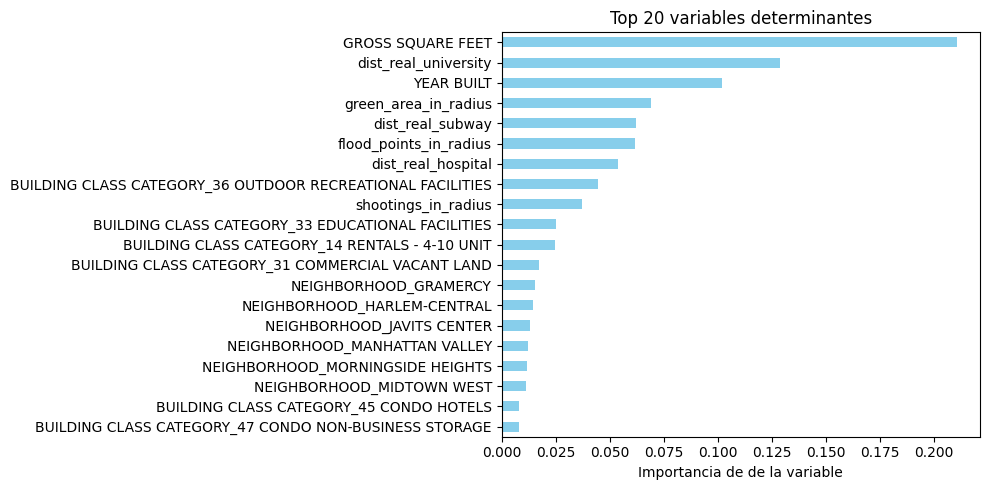

In [633]:
# --- Gráfico de variables y su importancia, generado con AI ---
importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=True)

plt.figure(figsize=(10, 5))
importances.tail(20).plot(kind='barh', color='skyblue')
plt.title('Top 20 variables determinantes')
plt.xlabel('Importancia de de la variable')
plt.tight_layout()
plt.show()

Con la librería IPhython.display, hacemos un mapa interactivo en el que el usuario puede mover los valores con los sliders, para poder encontrar las viviendas que se han vendido según ciertos parámetros, y ver como el modelo ajusta un precio aproximado, actualizando seguidamente el mapa con los puntos de las propiedades vendidas en ese rango de valores elegidos, con un threshold, esto es, un margen de libertad para la variable elegida, de 0.8. Es decir, el valor elegido para cada parámetro puede variar entre un 80% más o menos.

https://en.moonbooks.org/Articles/How-to-clear-the-output-in-a-Jupyter-Notebook-cell-after-each-for-loop-iteration-/

https://ipython.readthedocs.io/en/9.0.2/api/generated/IPython.display.html

https://medium.com/datasciencearth/map-visualization-with-folium-d1403771717

In [647]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Con la librerías importadas, hacemos unos sliders para
sq_ft_slider = widgets.IntSlider(value=4300, min=300, max=5000, step=50, description='Superficie (sq ft):')
subway_slider = widgets.IntSlider(value=400, min=0, max=3000, step=10, description='Dist. Metro (m):')
hospital_slider = widgets.IntSlider(value=600, min=0, max=5000, step=50, description='Dist. Hospital (m):')
university_slider = widgets.IntSlider(value=600, min=0, max=5000, step=50, description='Dist. Universidad (m):')

output_widget = widgets.Output()

def predict_and_map(sq_ft, dist_subway, dist_hospital, dist_university):
    # El output será:
    with output_widget:
        clear_output(wait=True)

        input_data = pd.DataFrame(0, index=[0], columns=X_train.columns)
        input_data['GROSS SQUARE FEET'] = sq_ft
        input_data['dist_real_subway'] = dist_subway
        input_data['dist_real_hospital'] = dist_hospital
        input_data['dist_real_university'] = dist_university

        predicted_log_price = rf_model.predict(input_data)
        predicted_price = np.exp(predicted_log_price)[0]

        print("---------------------------------------------------------")
        print(f"PRECIO ESTIMADO: ${predicted_price:,.2f}")
        print("---------------------------------------------------------")

        tolerance = .8 # Definimos un rango de tolerancia para las variables numéricas, en este caso +-80% del valor elegido

        min_price_range = predicted_price * (1 - tolerance)
        max_price_range = predicted_price * (1 + tolerance)

        # Filtramos el dataset para encontrar propiedades que coincidan con TODOS los criterios
        similar_properties = gdf_properties[
            (gdf_properties['SALE PRICE'] >= min_price_range) &
            (gdf_properties['SALE PRICE'] <= max_price_range) &
            (gdf_properties['GROSS SQUARE FEET'].between(sq_ft * (1-tolerance), sq_ft * (1+tolerance))) &
            (gdf_properties['dist_real_subway'].between(dist_subway * (1-tolerance), dist_subway * (1+tolerance))) &
            (gdf_properties['dist_real_hospital'].between(dist_hospital * (1-tolerance), dist_hospital * (1+tolerance))) &
            (gdf_properties['dist_real_university'].between(dist_university * (1-tolerance), dist_university * (1+tolerance)))
        ]

        if similar_properties.empty:
            print("No se encontraron propiedades con estos parámetros.")
        else:
            print(f"Se encontraron {len(similar_properties)} propiedades con estos parámetros!")

            # Creamos un folium y añadimos los puntos para las propiedades encontradas, con un popup para cada uno
            map_results = folium.Map(location=[40.78, -73.96], zoom_start=12, tiles="CartoDB positron") # Centrado en Manhattan, el centro!
            for _, row in similar_properties.iterrows():
                popup_html = f"""
                    <b><u>Información de la propiedad vendida:</u></b><br>
                    <b>Dirección:</b> {row['ADDRESS']}<br>
                    <b>Barrio:</b> {row['NEIGHBORHOOD']}<br>
                    <hr style='margin: 5px 0;'>
                    <b>Precio de venta:</b> ${row['SALE PRICE']:,.0f}<br>
                    <b>Superficie en pies cuadrados (FT):</b> {row['GROSS SQUARE FEET']:.0f}<br>
                    <b>Año de construcción:</b> {row['YEAR BUILT']:.0f}<br>
                    <hr style='margin: 5px 0;'>
                    <b><u>Análisis Geoespacial:</u></b><br>
                    <b>Dist. a Metro más cercano:</b> {row['dist_real_subway']:.0f} m<br>
                    <b>Dist. a Hospital más cercano:</b> {row['dist_real_hospital']:.0f} m<br>
                    <b>Dist. a Universidad más cercana:</b> {row['dist_real_university']:.0f} m<br>
                    <b>Tiroteos cercanos en el periodo de estudio:</b> {int(row['shootings_in_radius'])}<br>
                    <b>Puntos de inundación cercanos en el periodo de estudio:</b> {int(row['flood_points_in_radius'])}<br>
                    <b>Área verde en un area de 1km:</b> {int(row['green_area_in_radius'])} m^2<br>
                """
                                # Creamos el objeto Popup aquí, definiendo el ancho max como 600
                popup = folium.Popup(popup_html, max_width=600)

                # Agregamos el popup generado en este ciclo al objeto CircleMarker de folium
                folium.CircleMarker(
                    location=[row.geometry.y, row.geometry.x],
                    radius=6, color='red', fill=True, fill_color='violet',
                    popup=popup
                ).add_to(map_results)

            print("\nMostrando mapa con las ubicaciones de las propiedades encontradas...")
            display(map_results)

# Usamos los widgets generados, cada array contiene los sliders
widgets_panel = widgets.VBox([
    widgets.HBox([subway_slider, sq_ft_slider]),
    widgets.HBox([hospital_slider, university_slider]),
])

widgets.interactive_output(predict_and_map, {
    'sq_ft': sq_ft_slider, 'dist_subway': subway_slider,'dist_hospital': hospital_slider, 'dist_university': university_slider
})

display(widgets_panel, output_widget)

Output()